In [1]:
import numpy as np
import pandas as pd

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-fusion-2024-churn-features-6/__results__.html
/kaggle/input/data-fusion-2024-churn-features-6/main_tsf.csv
/kaggle/input/data-fusion-2024-churn-features-6/main_ft.csv
/kaggle/input/data-fusion-2024-churn-features-6/__notebook__.ipynb
/kaggle/input/data-fusion-2024-churn-features-6/__output__.json
/kaggle/input/data-fusion-2024-churn-features-6/custom.css
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/learn_error.tsv
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/catboost_training.json
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/time_left.tsv
/kaggle/input/data-fusion-2024-churn-features-6/catboost_info/learn/events.out.tfevents
/kaggle/input/ods-churn-24/currency_rk.csv
/kaggle/input/ods-churn-24/report_dates.csv
/kaggle/input/ods-churn-24/mcc_codes.csv
/kaggle/input/ods-churn-24/clients.csv
/kaggle/input/ods-churn-24/train.csv
/kaggle/input/ods-churn-24/sample_submit_naive.csv
/kaggle/input/ods-churn-24/transactions.cs

In [2]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import random
import warnings
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')
# pd.options.display.max_columns = 100
# pd.options.display.max_rows = 100
random.seed(42)
np.random.seed(42)

In [3]:
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

#### Features 1 

Бейзлайн 1

In [4]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

In [5]:
# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)

In [6]:
transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,^2_transaction_amt,^3_transaction_amt,^4_transaction_amt,^5_transaction_amt,^6_transaction_amt
0,3,3,1,-183.883957,2022-01-28 12:05:33,214.621146,0.000000,3,0.000000,-183.883957
1,3,3,1,-3206.437012,2022-01-28 12:52:30,214.588542,0.032604,3,0.032604,-3390.320969
2,3,16,1,-153866.890625,2022-02-16 14:45:56,195.509769,19.111377,16,19.078773,-157257.211594
3,3,56,1,-15144.601562,2022-03-09 19:58:29,174.292720,40.328426,56,21.217049,-172401.813156
4,3,0,1,5297.908691,2022-03-12 18:11:31,171.367002,43.254144,0,2.925718,-167103.904465
...,...,...,...,...,...,...,...,...,...,...
13075018,562740,155,1,-2484.366211,2023-03-20 11:52:09,101.630451,174.897500,155,0.940000,-137060.425721
13075019,562740,9,1,-187.658463,2023-03-20 12:10:22,101.617801,174.910150,9,0.012650,-137248.084183
13075020,562740,1,1,-891.933350,2023-03-20 15:53:37,101.462766,175.065185,1,0.155035,-138140.017533
13075021,562740,13,1,-464.467316,2023-03-20 15:54:49,101.461933,175.066019,13,0.000833,-138604.484848


In [7]:
clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

# Количество транзакций, по клиентам
count_trans = transactions['user_id'].value_counts().to_frame().reset_index()
count_trans = count_trans.sort_values(by='user_id')
count_trans.rename(columns={'count': 'count_trans'}, inplace=True)
count_trans.reset_index(drop=True, inplace=True)

# Сумма транзакций, по клиентам
sum_trans = transactions.groupby(['user_id'])[['transaction_amt']].sum().reset_index().\
rename(columns={"transaction_amt":"sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_2 = transactions.groupby(['user_id'])[['^2_transaction_amt']].sum().reset_index().\
rename(columns={"^2_transaction_amt":"^2_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_3 = transactions.groupby(['user_id'])[['^3_transaction_amt']].sum().reset_index().\
rename(columns={"^3_transaction_amt":"^3_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_4 = transactions.groupby(['user_id'])[['^4_transaction_amt']].sum().reset_index().\
rename(columns={"^4_transaction_amt":"^4_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_5 = transactions.groupby(['user_id'])[['^5_transaction_amt']].sum().reset_index().\
rename(columns={"^5_transaction_amt":"^5_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_6 = transactions.groupby(['user_id'])[['^6_transaction_amt']].sum().reset_index().\
rename(columns={"^6_transaction_amt":"^6_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Сумма положительный транзакций
sum_trans_p = transactions[transactions['transaction_amt']>0].groupby(['user_id'])[['transaction_amt']].sum().\
reset_index().rename(columns={"transaction_amt":"sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_p_2 = transactions[transactions['^2_transaction_amt']>0].groupby(['user_id'])[['^2_transaction_amt']].sum().\
reset_index().rename(columns={"^2_transaction_amt":"^2_sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_p_3 = transactions[transactions['^3_transaction_amt']>0].groupby(['user_id'])[['^3_transaction_amt']].sum().\
reset_index().rename(columns={"^3_transaction_amt":"^3_sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_p_4 = transactions[transactions['^4_transaction_amt']>0].groupby(['user_id'])[['^4_transaction_amt']].sum().\
reset_index().rename(columns={"^4_transaction_amt":"^4_sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_p_5 = transactions[transactions['^5_transaction_amt']>0].groupby(['user_id'])[['^5_transaction_amt']].sum().\
reset_index().rename(columns={"^5_transaction_amt":"^5_sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_p_6 = transactions[transactions['^6_transaction_amt']>0].groupby(['user_id'])[['^6_transaction_amt']].sum().\
reset_index().rename(columns={"^6_transaction_amt":"^6_sum_trans_p"}).sort_values(["user_id"]).reset_index(drop=True)

# Сумма отрицательных транзакций
sum_trans_m = transactions[transactions['transaction_amt']<0].groupby(['user_id'])[['transaction_amt']].sum().\
reset_index().rename(columns={"transaction_amt":"sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_m_2 = transactions[transactions['^2_transaction_amt']<0].groupby(['user_id'])[['^2_transaction_amt']].sum().\
reset_index().rename(columns={"^2_transaction_amt":"^2_sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_m_3 = transactions[transactions['^3_transaction_amt']<0].groupby(['user_id'])[['^3_transaction_amt']].sum().\
reset_index().rename(columns={"^3_transaction_amt":"^3_sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_m_4 = transactions[transactions['^4_transaction_amt']<0].groupby(['user_id'])[['^4_transaction_amt']].sum().\
reset_index().rename(columns={"^4_transaction_amt":"^4_sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_m_5 = transactions[transactions['^5_transaction_amt']<0].groupby(['user_id'])[['^5_transaction_amt']].sum().\
reset_index().rename(columns={"^5_transaction_amt":"^5_sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)
sum_trans_m_6 = transactions[transactions['^6_transaction_amt']<0].groupby(['user_id'])[['^6_transaction_amt']].sum().\
reset_index().rename(columns={"^6_transaction_amt":"^6_sum_trans_m"}).sort_values(["user_id"]).reset_index(drop=True)

# Количество дней от транзакции до отчета, по транзакциям
transactions['diff_days'] = (transactions['report_dt']-transactions['transaction_dttm']) / np.timedelta64(1, 'D')

# Максимальная дата до отчета, по клиентам
max_day_trans = transactions.groupby(['user_id'])[['diff_days']].max().reset_index().\
rename(columns={"diff_days":"max_day_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Минимальная дата до отчета, по клиентам
min_day_trans = transactions.groupby(['user_id'])[['diff_days']].min().reset_index().\
rename(columns={"diff_days":"min_day_trans"}).sort_values(["user_id"]).reset_index(drop=True)

In [8]:
clients=merge_by_concat(clients, count_trans, ['user_id'])
clients=merge_by_concat(clients, sum_trans, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m, ['user_id'])
clients=merge_by_concat(clients, sum_trans_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_6, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_6, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_6, ['user_id'])
clients=merge_by_concat(clients, max_day_trans, ['user_id'])
clients=merge_by_concat(clients, min_day_trans, ['user_id'])

clients['sum_trans_p'] = clients['sum_trans_p'].fillna(0)
clients['sum_trans_m'] = clients['sum_trans_m'].fillna(0)
clients['employee_count_nm'] = clients['employee_count_nm'].fillna(0)

clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.fillna(0, inplace=True)

clients.replace({'employee_count_nm':{'ОТ 101 ДО 500':1,'БОЛЕЕ 1001':2,'ОТ 501 ДО 1000':3,'ДО 10':4,
                                      'ОТ 11 ДО 50':5,'ОТ 51 ДО 100':6,'БОЛЕЕ 500':7,'ОТ 11 ДО 30':8,
                                      'ОТ 31 ДО 50':9}}, inplace=True)

clients['employee_count_nm'] = clients['employee_count_nm'].astype(np.int16)


clients['min_day_trans_log'] = clients['min_day_trans'].apply(lambda x: np.log(x))
clients['min_day_trans_log'] = clients['min_day_trans_log'].fillna(0)
clients['min_day_trans_age'] = clients['min_day_trans'] * clients['customer_age']

In [9]:
# np.log(main_1['min_day_trans'])

In [10]:
clients = clients[['user_id']+[el for el in clients.columns if '^' in el]]

In [11]:
clients

,user_id,^2_sum_trans,^2_sum_trans_p,^2_sum_trans_m,^3_sum_trans,^3_sum_trans_p,^3_sum_trans_m,^4_sum_trans,^4_sum_trans_p,^4_sum_trans_m,^5_sum_trans,^5_sum_trans_p,^5_sum_trans_m,^6_sum_trans,^6_sum_trans_p,^6_sum_trans_m
0,3,1710.051481,1710.051481,0.0,650.781123,650.781123,0.0,78,78.0,0.0,106.357083,106.357083,0.0,-1.125247e+06,1.370642e+04,-1.138953e+06
1,9,17878.549850,17878.549850,0.0,7644.324109,7644.324109,0.0,1512,1512.0,0.0,181.297581,181.297581,0.0,-1.015674e+07,0.000000e+00,-1.015674e+07
2,13,4456.248819,4456.248819,0.0,1761.307662,1761.307662,0.0,130,130.0,0.0,168.358495,168.358495,0.0,3.472063e+06,3.491287e+06,-1.922468e+04
3,37,58982.313275,58982.313275,0.0,30394.539850,30394.539850,0.0,2465,2465.0,0.0,179.022535,179.022535,0.0,-5.922063e+07,0.000000e+00,-5.922063e+07
4,41,2732.005694,2732.005694,0.0,1371.512639,1371.512639,0.0,531,531.0,0.0,153.207130,153.207130,0.0,-1.043332e+06,0.000000e+00,-1.043332e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,8331.575579,8331.575579,0.0,1532.582882,1532.582882,0.0,385,385.0,0.0,123.724942,123.724942,0.0,-7.933208e+05,0.000000e+00,-7.933208e+05
95996,562205,28434.418819,28434.418819,0.0,13905.827384,13905.827384,0.0,2954,2954.0,0.0,178.350035,178.350035,0.0,-2.342517e+06,6.348428e+03,-2.348865e+06
95997,562312,11769.801817,11769.801817,0.0,3923.870220,3923.870220,0.0,2760,2760.0,0.0,157.983009,157.983009,0.0,-5.400671e+05,0.000000e+00,-5.400671e+05
95998,562721,17949.776100,17949.776100,0.0,5925.340683,5925.340683,0.0,440,440.0,0.0,174.884363,174.884363,0.0,-5.560244e+06,1.087769e+03,-5.561332e+06


In [12]:
main_1 = clients.copy()
main_1_cat_cols = []
main_1_num_cols = []
for col in main_1.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_1[col].nunique() < 100:
            main_1_cat_cols.append(col)
        else:
            main_1_num_cols.append(col)
main_1

,user_id,^2_sum_trans,^2_sum_trans_p,^2_sum_trans_m,^3_sum_trans,^3_sum_trans_p,^3_sum_trans_m,^4_sum_trans,^4_sum_trans_p,^4_sum_trans_m,^5_sum_trans,^5_sum_trans_p,^5_sum_trans_m,^6_sum_trans,^6_sum_trans_p,^6_sum_trans_m
0,3,1710.051481,1710.051481,0.0,650.781123,650.781123,0.0,78,78.0,0.0,106.357083,106.357083,0.0,-1.125247e+06,1.370642e+04,-1.138953e+06
1,9,17878.549850,17878.549850,0.0,7644.324109,7644.324109,0.0,1512,1512.0,0.0,181.297581,181.297581,0.0,-1.015674e+07,0.000000e+00,-1.015674e+07
2,13,4456.248819,4456.248819,0.0,1761.307662,1761.307662,0.0,130,130.0,0.0,168.358495,168.358495,0.0,3.472063e+06,3.491287e+06,-1.922468e+04
3,37,58982.313275,58982.313275,0.0,30394.539850,30394.539850,0.0,2465,2465.0,0.0,179.022535,179.022535,0.0,-5.922063e+07,0.000000e+00,-5.922063e+07
4,41,2732.005694,2732.005694,0.0,1371.512639,1371.512639,0.0,531,531.0,0.0,153.207130,153.207130,0.0,-1.043332e+06,0.000000e+00,-1.043332e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,8331.575579,8331.575579,0.0,1532.582882,1532.582882,0.0,385,385.0,0.0,123.724942,123.724942,0.0,-7.933208e+05,0.000000e+00,-7.933208e+05
95996,562205,28434.418819,28434.418819,0.0,13905.827384,13905.827384,0.0,2954,2954.0,0.0,178.350035,178.350035,0.0,-2.342517e+06,6.348428e+03,-2.348865e+06
95997,562312,11769.801817,11769.801817,0.0,3923.870220,3923.870220,0.0,2760,2760.0,0.0,157.983009,157.983009,0.0,-5.400671e+05,0.000000e+00,-5.400671e+05
95998,562721,17949.776100,17949.776100,0.0,5925.340683,5925.340683,0.0,440,440.0,0.0,174.884363,174.884363,0.0,-5.560244e+06,1.087769e+03,-5.561332e+06


In [13]:
main_1_cat_cols, main_1_num_cols

(['^2_sum_trans_m', '^3_sum_trans_m', '^4_sum_trans_m', '^5_sum_trans_m'],
 ['^2_sum_trans',
  '^2_sum_trans_p',
  '^3_sum_trans',
  '^3_sum_trans_p',
  '^4_sum_trans',
  '^4_sum_trans_p',
  '^5_sum_trans',
  '^5_sum_trans_p',
  '^6_sum_trans',
  '^6_sum_trans_p',
  '^6_sum_trans_m'])

#### Features 2

ChatGPT

In [14]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

In [15]:
# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)

In [16]:
clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

# chatgpt features

# Calculate time decayed sum of transactions
transactions['days_since_transaction'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.days
transactions['time_decay_factor'] = np.exp(-0.05 * transactions['days_since_transaction'])  # Adjust decay rate as needed
transactions['time_decayed_trans_amt'] = transactions['transaction_amt'] * transactions['time_decay_factor']
transactions['^2_time_decayed_trans_amt'] = transactions['^2_transaction_amt'] * transactions['time_decay_factor']
transactions['^3_time_decayed_trans_amt'] = transactions['^3_transaction_amt'] * transactions['time_decay_factor']
transactions['^4_time_decayed_trans_amt'] = transactions['^4_transaction_amt'] * transactions['time_decay_factor']
transactions['^5_time_decayed_trans_amt'] = transactions['^5_transaction_amt'] * transactions['time_decay_factor']
transactions['^6_time_decayed_trans_amt'] = transactions['^6_transaction_amt'] * transactions['time_decay_factor']
# Sum of time decayed transactions
time_decayed_sum = transactions.groupby(['user_id'])[['time_decayed_trans_amt']].sum().reset_index().rename(columns={"time_decayed_trans_amt":"time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
time_decayed_sum_2 = transactions.groupby(['user_id'])[['^2_time_decayed_trans_amt']].sum().reset_index().rename(columns={"^2_time_decayed_trans_amt":"^2_time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
time_decayed_sum_3 = transactions.groupby(['user_id'])[['^3_time_decayed_trans_amt']].sum().reset_index().rename(columns={"^3_time_decayed_trans_amt":"^3_time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
time_decayed_sum_4 = transactions.groupby(['user_id'])[['^4_time_decayed_trans_amt']].sum().reset_index().rename(columns={"^4_time_decayed_trans_amt":"^4_time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
time_decayed_sum_5 = transactions.groupby(['user_id'])[['^5_time_decayed_trans_amt']].sum().reset_index().rename(columns={"^5_time_decayed_trans_amt":"^5_time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)
time_decayed_sum_6 = transactions.groupby(['user_id'])[['^6_time_decayed_trans_amt']].sum().reset_index().rename(columns={"^6_time_decayed_trans_amt":"^6_time_decayed_sum_trans"}).sort_values(["user_id"]).reset_index(drop=True)

# Count unique MCC codes per client
unique_mcc = transactions.groupby('user_id')['mcc_code'].nunique().reset_index(name='unique_mcc_count')

# Count unique currencies per client
unique_currencies = transactions.groupby('user_id')['currency_rk'].nunique().reset_index(name='unique_currency_count')

# Frequency of transactions in the last quarter (or any relevant period)
transactions['quarter'] = transactions['transaction_dttm'].dt.quarter
last_quarter_trans = transactions[transactions['quarter'] == transactions['quarter'].max()]
trans_freq_last_quarter = last_quarter_trans.groupby('user_id').size().reset_index(name='last_quarter_trans_count')

# Variability in transaction amounts
trans_amount_std = transactions.groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std')
trans_amount_std_2 = transactions.groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std')
trans_amount_std_3 = transactions.groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std')
trans_amount_std_4 = transactions.groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std')
trans_amount_std_5 = transactions.groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std')
trans_amount_std_6 = transactions.groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std')
trans_amount_mean = transactions.groupby('user_id')['transaction_amt'].mean().reset_index(name='trans_amount_mean')
trans_amount_mean_2 = transactions.groupby('user_id')['^2_transaction_amt'].mean().reset_index(name='^2_trans_amount_mean')
trans_amount_mean_3 = transactions.groupby('user_id')['^3_transaction_amt'].mean().reset_index(name='^3_trans_amount_mean')
trans_amount_mean_4 = transactions.groupby('user_id')['^4_transaction_amt'].mean().reset_index(name='^4_trans_amount_mean')
trans_amount_mean_5 = transactions.groupby('user_id')['^5_transaction_amt'].mean().reset_index(name='^5_trans_amount_mean')
trans_amount_mean_6 = transactions.groupby('user_id')['^6_transaction_amt'].mean().reset_index(name='^6_trans_amount_mean')
trans_amount_median = transactions.groupby('user_id')['transaction_amt'].median().reset_index(name='trans_amount_median')
trans_amount_median_2 = transactions.groupby('user_id')['^2_transaction_amt'].median().reset_index(name='^2_trans_amount_median')
trans_amount_median_3 = transactions.groupby('user_id')['^3_transaction_amt'].median().reset_index(name='^3_trans_amount_median')
trans_amount_median_4 = transactions.groupby('user_id')['^4_transaction_amt'].median().reset_index(name='^4_trans_amount_median')
trans_amount_median_5 = transactions.groupby('user_id')['^5_transaction_amt'].median().reset_index(name='^5_trans_amount_median')
trans_amount_median_6 = transactions.groupby('user_id')['^6_transaction_amt'].median().reset_index(name='^6_trans_amount_median')
trans_amount_std_mcc_0 = transactions[transactions.mcc_code==0].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_0')
trans_amount_std_mcc_1 = transactions[transactions.mcc_code==1].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_1')
trans_amount_std_mcc_2 = transactions[transactions.mcc_code==2].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_2')
trans_amount_std_mcc_3 = transactions[transactions.mcc_code==3].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_3')
trans_amount_std_mcc_4 = transactions[transactions.mcc_code==4].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_4')
trans_amount_std_mcc_12 = transactions[transactions.mcc_code==12].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_12')
trans_amount_std_mcc_28 = transactions[transactions.mcc_code==28].groupby('user_id')['transaction_amt'].std().reset_index(name='trans_amount_std_mcc_28')
trans_amount_std_mcc_0_2 = transactions[transactions.mcc_code==0].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_0')
trans_amount_std_mcc_1_2 = transactions[transactions.mcc_code==1].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_1')
trans_amount_std_mcc_2_2 = transactions[transactions.mcc_code==2].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_2')
trans_amount_std_mcc_3_2 = transactions[transactions.mcc_code==3].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_3')
trans_amount_std_mcc_4_2 = transactions[transactions.mcc_code==4].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_4')
trans_amount_std_mcc_12_2 = transactions[transactions.mcc_code==12].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_12')
trans_amount_std_mcc_28_2 = transactions[transactions.mcc_code==28].groupby('user_id')['^2_transaction_amt'].std().reset_index(name='^2_trans_amount_std_mcc_28')
trans_amount_std_mcc_0_3 = transactions[transactions.mcc_code==0].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_0')
trans_amount_std_mcc_1_3 = transactions[transactions.mcc_code==1].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_1')
trans_amount_std_mcc_2_3 = transactions[transactions.mcc_code==2].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_2')
trans_amount_std_mcc_3_3 = transactions[transactions.mcc_code==3].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_3')
trans_amount_std_mcc_4_3 = transactions[transactions.mcc_code==4].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_4')
trans_amount_std_mcc_12_3 = transactions[transactions.mcc_code==12].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_12')
trans_amount_std_mcc_28_3 = transactions[transactions.mcc_code==28].groupby('user_id')['^3_transaction_amt'].std().reset_index(name='^3_trans_amount_std_mcc_28')
trans_amount_std_mcc_0_4 = transactions[transactions.mcc_code==0].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_0')
trans_amount_std_mcc_1_4 = transactions[transactions.mcc_code==1].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_1')
trans_amount_std_mcc_2_4 = transactions[transactions.mcc_code==2].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_2')
trans_amount_std_mcc_3_4 = transactions[transactions.mcc_code==3].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_3')
trans_amount_std_mcc_4_4 = transactions[transactions.mcc_code==4].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_4')
trans_amount_std_mcc_12_4 = transactions[transactions.mcc_code==12].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_12')
trans_amount_std_mcc_28_4 = transactions[transactions.mcc_code==28].groupby('user_id')['^4_transaction_amt'].std().reset_index(name='^4_trans_amount_std_mcc_28')
trans_amount_std_mcc_0_5 = transactions[transactions.mcc_code==0].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_0')
trans_amount_std_mcc_1_5 = transactions[transactions.mcc_code==1].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_1')
trans_amount_std_mcc_2_5 = transactions[transactions.mcc_code==2].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_2')
trans_amount_std_mcc_3_5 = transactions[transactions.mcc_code==3].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_3')
trans_amount_std_mcc_4_5 = transactions[transactions.mcc_code==4].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_4')
trans_amount_std_mcc_12_5 = transactions[transactions.mcc_code==12].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_12')
trans_amount_std_mcc_28_5 = transactions[transactions.mcc_code==28].groupby('user_id')['^5_transaction_amt'].std().reset_index(name='^5_trans_amount_std_mcc_28')
trans_amount_std_mcc_0_6 = transactions[transactions.mcc_code==0].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_0')
trans_amount_std_mcc_1_6 = transactions[transactions.mcc_code==1].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_1')
trans_amount_std_mcc_2_6 = transactions[transactions.mcc_code==2].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_2')
trans_amount_std_mcc_3_6 = transactions[transactions.mcc_code==3].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_3')
trans_amount_std_mcc_4_6 = transactions[transactions.mcc_code==4].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_4')
trans_amount_std_mcc_12_6 = transactions[transactions.mcc_code==12].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_12')
trans_amount_std_mcc_28_6 = transactions[transactions.mcc_code==28].groupby('user_id')['^6_transaction_amt'].std().reset_index(name='^6_trans_amount_std_mcc_28')

# Trend in transaction amount over time (e.g., increasing, decreasing)
# You could fit a simple linear regression to transaction amounts over time for each user and use the slope as a feature
from sklearn.linear_model import LinearRegression
def calculate_trend(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['transaction_amt'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line
transaction_trends = transactions.groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend')

transactions['month_year'] = transactions['transaction_dttm'].dt.to_period('M')
monthly_trans_mean = transactions.groupby(['user_id'])['transaction_amt'].mean().reset_index(name='monthly_trans_mean')
monthly_trans_count = transactions.groupby(['user_id'])['transaction_amt'].count().reset_index(name='monthly_trans_count')
monthly_trans_mean_2 = transactions.groupby(['user_id'])['^2_transaction_amt'].mean().reset_index(name='^2_monthly_trans_mean')
monthly_trans_count_2 = transactions.groupby(['user_id'])['^2_transaction_amt'].count().reset_index(name='^2_monthly_trans_count')
monthly_trans_mean_3 = transactions.groupby(['user_id'])['^3_transaction_amt'].mean().reset_index(name='^3_monthly_trans_mean')
monthly_trans_count_3 = transactions.groupby(['user_id'])['^3_transaction_amt'].count().reset_index(name='^3_monthly_trans_count')
monthly_trans_mean_4 = transactions.groupby(['user_id'])['^4_transaction_amt'].mean().reset_index(name='^4_monthly_trans_mean')
monthly_trans_count_4 = transactions.groupby(['user_id'])['^4_transaction_amt'].count().reset_index(name='^4_monthly_trans_count')
monthly_trans_mean_5 = transactions.groupby(['user_id'])['^5_transaction_amt'].mean().reset_index(name='^5_monthly_trans_mean')
monthly_trans_count_5 = transactions.groupby(['user_id'])['^5_transaction_amt'].count().reset_index(name='^5_monthly_trans_count')
monthly_trans_mean_6 = transactions.groupby(['user_id'])['^6_transaction_amt'].mean().reset_index(name='^6_monthly_trans_mean')
monthly_trans_count_6 = transactions.groupby(['user_id'])['^6_transaction_amt'].count().reset_index(name='^6_monthly_trans_count')

transactions['cheap_trans'] = (abs(transactions['transaction_amt']) < 100).astype(int)
cheap_trans_count = transactions.groupby('user_id')['cheap_trans'].sum().reset_index(name='cheap_trans_count')
transactions['^2_cheap_trans'] = (abs(transactions['^2_transaction_amt']) < 100).astype(int)
cheap_trans_count_2 = transactions.groupby('user_id')['^2_cheap_trans'].sum().reset_index(name='^2_cheap_trans_count')
transactions['^3_cheap_trans'] = (abs(transactions['^3_transaction_amt']) < 100).astype(int)
cheap_trans_count_3 = transactions.groupby('user_id')['^3_cheap_trans'].sum().reset_index(name='^3_cheap_trans_count')
transactions['^4_cheap_trans'] = (abs(transactions['^4_transaction_amt']) < 100).astype(int)
cheap_trans_count_4 = transactions.groupby('user_id')['^4_cheap_trans'].sum().reset_index(name='^4_cheap_trans_count')
transactions['^5_cheap_trans'] = (abs(transactions['^5_transaction_amt']) < 100).astype(int)
cheap_trans_count_5 = transactions.groupby('user_id')['^5_cheap_trans'].sum().reset_index(name='^5_cheap_trans_count')
transactions['^6_cheap_trans'] = (abs(transactions['^6_transaction_amt']) < 100).astype(int)
cheap_trans_count_6 = transactions.groupby('user_id')['^6_cheap_trans'].sum().reset_index(name='^6_cheap_trans_count')

transactions['is_weekend'] = transactions['transaction_dttm'].dt.dayofweek >= 5
weekend_trans_count = transactions.groupby('user_id')['is_weekend'].sum().reset_index(name='weekend_trans_count')

In [17]:
clients = merge_by_concat(clients, time_decayed_sum, ['user_id'])
clients = merge_by_concat(clients, time_decayed_sum_2, ['user_id'])
clients = merge_by_concat(clients, time_decayed_sum_3, ['user_id'])
clients = merge_by_concat(clients, time_decayed_sum_4, ['user_id'])
clients = merge_by_concat(clients, time_decayed_sum_5, ['user_id'])
clients = merge_by_concat(clients, time_decayed_sum_6, ['user_id'])
clients = merge_by_concat(clients, unique_mcc, ['user_id'])
clients = merge_by_concat(clients, unique_currencies, ['user_id'])
clients = merge_by_concat(clients, trans_freq_last_quarter, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_mean_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_median_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28_2, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28_3, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28_4, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28_5, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_0_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_1_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_2_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_3_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_4_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_12_6, ['user_id'])
clients = merge_by_concat(clients, trans_amount_std_mcc_28_6, ['user_id'])
clients = merge_by_concat(clients, transaction_trends, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean_2, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count_2, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean_3, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count_3, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean_4, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count_4, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean_5, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count_5, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_mean_6, ['user_id'])
clients = merge_by_concat(clients, monthly_trans_count_6, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count_2, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count_3, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count_4, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count_5, ['user_id'])
clients = merge_by_concat(clients, cheap_trans_count_6, ['user_id'])
clients = merge_by_concat(clients, weekend_trans_count, ['user_id'])

# Снова добавляем фичи из первого блока фичей, но потом их удалим в этом блоке
clients=merge_by_concat(clients, sum_trans_p, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m, ['user_id'])
clients=merge_by_concat(clients, sum_trans, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_2, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_3, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_4, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_5, ['user_id'])
clients=merge_by_concat(clients, sum_trans_p_6, ['user_id'])
clients=merge_by_concat(clients, sum_trans_m_6, ['user_id'])
clients=merge_by_concat(clients, sum_trans_6, ['user_id'])
clients=merge_by_concat(clients, count_trans, ['user_id'])
clients=merge_by_concat(clients, max_day_trans, ['user_id'])
clients=merge_by_concat(clients, min_day_trans, ['user_id'])

cols_for_removing = ['sum_trans_p', 'sum_trans_m', 'sum_trans', 'count_trans',
                     'max_day_trans', 'min_day_trans',
                     '2^_sum_trans_p', '2^_sum_trans_m', '2^_sum_trans',
                     '3^_sum_trans_p', '3^_sum_trans_m', '3^_sum_trans',
                     '4^_sum_trans_p', '4^_sum_trans_m', '4^_sum_trans',
                     '5^_sum_trans_p', '5^_sum_trans_m', '5^_sum_trans',
                     '6^_sum_trans_p', '6^_sum_trans_m', '6^_sum_trans']

In [18]:
clients['pos_neg_trans_ratio'] = clients['sum_trans_p'] / (clients['sum_trans_m'] + 1)  # Adding 1 to avoid division by zero
clients['^2_pos_neg_trans_ratio'] = clients['^2_sum_trans_p'] / (clients['^2_sum_trans_m'] + 1)
clients['^3_pos_neg_trans_ratio'] = clients['^3_sum_trans_p'] / (clients['^3_sum_trans_m'] + 1)
clients['^4_pos_neg_trans_ratio'] = clients['^4_sum_trans_p'] / (clients['^4_sum_trans_m'] + 1)
clients['^5_pos_neg_trans_ratio'] = clients['^5_sum_trans_p'] / (clients['^5_sum_trans_m'] + 1)
clients['^6_pos_neg_trans_ratio'] = clients['^6_sum_trans_p'] / (clients['^6_sum_trans_m'] + 1)

# 1. Interaction terms (product of two columns)
clients['trans_amount_age_interaction'] = clients['trans_amount_std'] * clients['customer_age']
clients['^2_trans_amount_age_interaction'] = clients['^2_trans_amount_std'] * clients['customer_age']
clients['^3_trans_amount_age_interaction'] = clients['^3_trans_amount_std'] * clients['customer_age']
clients['^4_trans_amount_age_interaction'] = clients['^4_trans_amount_std'] * clients['customer_age']
clients['^5_trans_amount_age_interaction'] = clients['^5_trans_amount_std'] * clients['customer_age']
clients['^6_trans_amount_age_interaction'] = clients['^6_trans_amount_std'] * clients['customer_age']
clients['trans_amount_age_interaction2'] = clients['trans_amount_mean'] * clients['customer_age']
clients['^2_trans_amount_age_interaction2'] = clients['^2_trans_amount_mean'] * clients['customer_age']
clients['^3_trans_amount_age_interaction2'] = clients['^3_trans_amount_mean'] * clients['customer_age']
clients['^4_trans_amount_age_interaction2'] = clients['^4_trans_amount_mean'] * clients['customer_age']
clients['^5_trans_amount_age_interaction2'] = clients['^5_trans_amount_mean'] * clients['customer_age']
clients['^6_trans_amount_age_interaction2'] = clients['^6_trans_amount_mean'] * clients['customer_age']
clients['trans_amount_age_interaction3'] = clients['trans_amount_median'] * clients['customer_age']
clients['^2_trans_amount_age_interaction3'] = clients['^2_trans_amount_median'] * clients['customer_age']
clients['^3_trans_amount_age_interaction3'] = clients['^3_trans_amount_median'] * clients['customer_age']
clients['^4_trans_amount_age_interaction3'] = clients['^4_trans_amount_median'] * clients['customer_age']
clients['^5_trans_amount_age_interaction3'] = clients['^5_trans_amount_median'] * clients['customer_age']
clients['^6_trans_amount_age_interaction3'] = clients['^6_trans_amount_median'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_0'] = clients['trans_amount_std_mcc_0'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_1'] = clients['trans_amount_std_mcc_1'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_2'] = clients['trans_amount_std_mcc_2'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_3'] = clients['trans_amount_std_mcc_3'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_4'] = clients['trans_amount_std_mcc_4'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_12'] = clients['trans_amount_std_mcc_12'] * clients['customer_age']
clients['trans_amount_age_interaction_mcc_28'] = clients['trans_amount_std_mcc_28'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_0'] = clients['^2_trans_amount_std_mcc_0'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_1'] = clients['^2_trans_amount_std_mcc_1'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_2'] = clients['^2_trans_amount_std_mcc_2'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_3'] = clients['^2_trans_amount_std_mcc_3'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_4'] = clients['^2_trans_amount_std_mcc_4'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_12'] = clients['^2_trans_amount_std_mcc_12'] * clients['customer_age']
clients['^2_trans_amount_age_interaction_mcc_28'] = clients['^2_trans_amount_std_mcc_28'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_0'] = clients['^3_trans_amount_std_mcc_0'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_1'] = clients['^3_trans_amount_std_mcc_1'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_2'] = clients['^3_trans_amount_std_mcc_2'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_3'] = clients['^3_trans_amount_std_mcc_3'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_4'] = clients['^3_trans_amount_std_mcc_4'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_12'] = clients['^3_trans_amount_std_mcc_12'] * clients['customer_age']
clients['^3_trans_amount_age_interaction_mcc_28'] = clients['^3_trans_amount_std_mcc_28'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_0'] = clients['^4_trans_amount_std_mcc_0'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_1'] = clients['^4_trans_amount_std_mcc_1'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_2'] = clients['^4_trans_amount_std_mcc_2'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_3'] = clients['^4_trans_amount_std_mcc_3'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_4'] = clients['^4_trans_amount_std_mcc_4'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_12'] = clients['^4_trans_amount_std_mcc_12'] * clients['customer_age']
clients['^4_trans_amount_age_interaction_mcc_28'] = clients['^4_trans_amount_std_mcc_28'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_0'] = clients['^5_trans_amount_std_mcc_0'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_1'] = clients['^5_trans_amount_std_mcc_1'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_2'] = clients['^5_trans_amount_std_mcc_2'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_3'] = clients['^5_trans_amount_std_mcc_3'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_4'] = clients['^5_trans_amount_std_mcc_4'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_12'] = clients['^5_trans_amount_std_mcc_12'] * clients['customer_age']
clients['^5_trans_amount_age_interaction_mcc_28'] = clients['^5_trans_amount_std_mcc_28'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_0'] = clients['^6_trans_amount_std_mcc_0'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_1'] = clients['^6_trans_amount_std_mcc_1'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_2'] = clients['^6_trans_amount_std_mcc_2'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_3'] = clients['^6_trans_amount_std_mcc_3'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_4'] = clients['^6_trans_amount_std_mcc_4'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_12'] = clients['^6_trans_amount_std_mcc_12'] * clients['customer_age']
clients['^6_trans_amount_age_interaction_mcc_28'] = clients['^6_trans_amount_std_mcc_28'] * clients['customer_age']

# 2. Squared features (to capture non-linear effects)
clients['age_squared'] = clients['customer_age'] ** 2

# 3. Logarithm of features (to handle skewed distributions)
clients['log_sum_trans'] = np.log1p(clients['sum_trans'])
clients['^2_log_sum_trans'] = np.log1p(clients['^2_sum_trans'])
clients['^3_log_sum_trans'] = np.log1p(clients['^3_sum_trans'])
clients['^4_log_sum_trans'] = np.log1p(clients['^4_sum_trans'])
clients['^5_log_sum_trans'] = np.log1p(clients['^5_sum_trans'])
clients['^6_log_sum_trans'] = np.log1p(clients['^6_sum_trans'])

# 4. Ratio features (one feature divided by another)
clients['trans_per_day'] = clients['count_trans'] / (clients['max_day_trans'] - clients['min_day_trans'] + 1)

# 5. Aggregated features (e.g., mean transactions amount per unique MCC)
clients['avg_trans_per_mcc'] = clients['sum_trans'] / clients['unique_mcc_count']
clients['^2_avg_trans_per_mcc'] = clients['^2_sum_trans'] / clients['unique_mcc_count']
clients['^3_avg_trans_per_mcc'] = clients['^3_sum_trans'] / clients['unique_mcc_count']
clients['^4_avg_trans_per_mcc'] = clients['^4_sum_trans'] / clients['unique_mcc_count']
clients['^5_avg_trans_per_mcc'] = clients['^5_sum_trans'] / clients['unique_mcc_count']
clients['^6_avg_trans_per_mcc'] = clients['^6_sum_trans'] / clients['unique_mcc_count']

# 9. Time since last transaction
clients['days_since_last_trans'] = (clients['max_day_trans'] - clients['min_day_trans']).clip(lower=0)

# 10. Frequency encoding (e.g., how common is a certain employee count)
clients['employee_count_freq'] = clients['employee_count_nm'].map(clients['employee_count_nm'].value_counts() / len(clients))
clients['customer_age_freq'] = clients['customer_age'].map(clients['customer_age'].value_counts() / len(clients))

# 12. Polynomial features (interaction of features to a certain degree)
clients['age_count_trans_interaction'] = clients['customer_age'] * clients['count_trans']
clients['age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['cheap_trans_count']
clients['age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['monthly_trans_count']
clients['^2_age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['^2_cheap_trans_count']
clients['^2_age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['^2_monthly_trans_count']
clients['^3_age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['^3_cheap_trans_count']
clients['^3_age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['^3_monthly_trans_count']
clients['^4_age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['^4_cheap_trans_count']
clients['^4_age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['^4_monthly_trans_count']
clients['^5_age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['^5_cheap_trans_count']
clients['^5_age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['^5_monthly_trans_count']
clients['^6_age_cheap_trans_count_interaction'] = clients['customer_age'] * clients['^6_cheap_trans_count']
clients['^6_age_monthly_trans_count_interaction'] = clients['customer_age'] * clients['^6_monthly_trans_count']

# 15. Difference from mean (transaction amount difference from the mean)
clients['diff_trans_mean'] = clients['sum_trans'] - clients['sum_trans'].mean()
clients['^2_diff_trans_mean'] = clients['^2_sum_trans'] - clients['^2_sum_trans'].mean()
clients['^3_diff_trans_mean'] = clients['^3_sum_trans'] - clients['^3_sum_trans'].mean()
clients['^4_diff_trans_mean'] = clients['^4_sum_trans'] - clients['^4_sum_trans'].mean()
clients['^5_diff_trans_mean'] = clients['^5_sum_trans'] - clients['^5_sum_trans'].mean()
clients['^6_diff_trans_mean'] = clients['^6_sum_trans'] - clients['^6_sum_trans'].mean()

# 16. Z-score normalization (standardizing the transaction amount)
clients['z_score_trans'] = (clients['sum_trans'] - clients['sum_trans'].mean()) / clients['sum_trans'].std()
clients['^2_z_score_trans'] = (clients['^2_sum_trans'] - clients['^2_sum_trans'].mean()) / clients['^2_sum_trans'].std()
clients['^3_z_score_trans'] = (clients['^3_sum_trans'] - clients['^3_sum_trans'].mean()) / clients['^3_sum_trans'].std()
clients['^4_z_score_trans'] = (clients['^4_sum_trans'] - clients['^4_sum_trans'].mean()) / clients['^4_sum_trans'].std()
clients['^5_z_score_trans'] = (clients['^5_sum_trans'] - clients['^5_sum_trans'].mean()) / clients['^5_sum_trans'].std()
clients['^6_z_score_trans'] = (clients['^6_sum_trans'] - clients['^6_sum_trans'].mean()) / clients['^6_sum_trans'].std()

In [19]:
clients['last_quarter_trans_count'] = clients['last_quarter_trans_count'].fillna(0)
clients['pos_neg_trans_ratio'] = clients['pos_neg_trans_ratio'].fillna(0)

clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.fillna(0, inplace=True)

In [23]:
clients = clients[['user_id']+[el for el in clients.columns if '^' in el]]

In [24]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_2 = clients[[el for el in clients.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_2_cat_cols = []
main_2_num_cols = []
for col in main_2.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_2[col].nunique() < 100:
            main_2_cat_cols.append(col)
        else:
            main_2_num_cols.append(col)
main_2

,user_id,^2_time_decayed_sum_trans,^3_time_decayed_sum_trans,^4_time_decayed_sum_trans,^5_time_decayed_sum_trans,^6_time_decayed_sum_trans,^2_trans_amount_std,^3_trans_amount_std,^4_trans_amount_std,^5_trans_amount_std,^6_trans_amount_std,^2_trans_amount_mean,^3_trans_amount_mean,^4_trans_amount_mean,^5_trans_amount_mean,^6_trans_amount_mean,^2_trans_amount_median,^3_trans_amount_median,^4_trans_amount_median,^5_trans_amount_median,^6_trans_amount_median,^2_trans_amount_std_mcc_0,^2_trans_amount_std_mcc_1,^2_trans_amount_std_mcc_2,^2_trans_amount_std_mcc_3,^2_trans_amount_std_mcc_4,^2_trans_amount_std_mcc_12,^2_trans_amount_std_mcc_28,^3_trans_amount_std_mcc_0,^3_trans_amount_std_mcc_1,^3_trans_amount_std_mcc_2,^3_trans_amount_std_mcc_3,^3_trans_amount_std_mcc_4,^3_trans_amount_std_mcc_12,^3_trans_amount_std_mcc_28,^4_trans_amount_std_mcc_0,^4_trans_amount_std_mcc_1,^4_trans_amount_std_mcc_2,^4_trans_amount_std_mcc_3,^4_trans_amount_std_mcc_4,^4_trans_amount_std_mcc_12,^4_trans_amount_std_mcc_28,^5_trans_amount_std_mcc_0,^5_trans_amount_std_mcc_1,^5_trans_amount_std_mcc_2,^5_trans_amount_std_mcc_3,^5_trans_amount_std_mcc_4,^5_trans_amount_std_mcc_12,^5_trans_amount_std_mcc_28,^6_trans_amount_std_mcc_0,^6_trans_amount_std_mcc_1,^6_trans_amount_std_mcc_2,^6_trans_amount_std_mcc_3,^6_trans_amount_std_mcc_4,^6_trans_amount_std_mcc_12,^6_trans_amount_std_mcc_28,^2_monthly_trans_mean,^2_monthly_trans_count,^3_monthly_trans_mean,^3_monthly_trans_count,^4_monthly_trans_mean,^4_monthly_trans_count,^5_monthly_trans_mean,^5_monthly_trans_count,^6_monthly_trans_mean,^6_monthly_trans_count,^2_cheap_trans_count,^3_cheap_trans_count,^4_cheap_trans_count,^5_cheap_trans_count,^6_cheap_trans_count,^2_sum_trans_p,^2_sum_trans_m,^2_sum_trans,^3_sum_trans_p,^3_sum_trans_m,^3_sum_trans,^4_sum_trans_p,^4_sum_trans_m,^4_sum_trans,^5_sum_trans_p,^5_sum_trans_m,^5_sum_trans,^6_sum_trans_p,^6_sum_trans_m,^6_sum_trans,^2_pos_neg_trans_ratio,^3_pos_neg_trans_ratio,^4_pos_neg_trans_ratio,^5_pos_neg_trans_ratio,^6_pos_neg_trans_ratio,^2_trans_amount_age_interaction,^3_trans_amount_age_interaction,^4_trans_amount_age_interaction,^5_trans_amount_age_interaction,^6_trans_amount_age_interaction,^2_trans_amount_age_interaction2,^3_trans_amount_age_interaction2,^4_trans_amount_age_interaction2,^5_trans_amount_age_interaction2,^6_trans_amount_age_interaction2,^2_trans_amount_age_interaction3,^3_trans_amount_age_interaction3,^4_trans_amount_age_interaction3,^5_trans_amount_age_interaction3,^6_trans_amount_age_interaction3,^2_trans_amount_age_interaction_mcc_0,^2_trans_amount_age_interaction_mcc_1,^2_trans_amount_age_interaction_mcc_2,^2_trans_amount_age_interaction_mcc_3,^2_trans_amount_age_interaction_mcc_4,^2_trans_amount_age_interaction_mcc_12,^2_trans_amount_age_interaction_mcc_28,^3_trans_amount_age_interaction_mcc_0,^3_trans_amount_age_interaction_mcc_1,^3_trans_amount_age_interaction_mcc_2,^3_trans_amount_age_interaction_mcc_3,^3_trans_amount_age_interaction_mcc_4,^3_trans_amount_age_interaction_mcc_12,^3_trans_amount_age_interaction_mcc_28,^4_trans_amount_age_interaction_mcc_0,^4_trans_amount_age_interaction_mcc_1,^4_trans_amount_age_interaction_mcc_2,^4_trans_amount_age_interaction_mcc_3,^4_trans_amount_age_interaction_mcc_4,^4_trans_amount_age_interaction_mcc_12,^4_trans_amount_age_interaction_mcc_28,^5_trans_amount_age_interaction_mcc_0,^5_trans_amount_age_interaction_mcc_1,^5_trans_amount_age_interaction_mcc_2,^5_trans_amount_age_interaction_mcc_3,^5_trans_amount_age_interaction_mcc_4,^5_trans_amount_age_interaction_mcc_12,^5_trans_amount_age_interaction_mcc_28,^6_trans_amount_age_interaction_mcc_0,^6_trans_amount_age_interaction_mcc_1,^6_trans_amount_age_interaction_mcc_2,^6_trans_amount_age_interaction_mcc_3,^6_trans_amount_age_interaction_mcc_4,^6_trans_amount_age_interaction_mcc_12,^6_trans_amount_age_interaction_mcc_28,^2_log_sum_trans,^3_log_sum_trans,^4_log_sum_trans,^5_log_sum_trans,^6_log_sum_trans,^2_avg_trans_per_mcc,^3_avg_trans_per_mcc,^4_a

In [25]:
main_2_cat_cols, main_2_num_cols

(['^4_trans_amount_std_mcc_0',
  '^4_trans_amount_std_mcc_1',
  '^4_trans_amount_std_mcc_2',
  '^4_trans_amount_std_mcc_3',
  '^4_trans_amount_std_mcc_4',
  '^4_trans_amount_std_mcc_12',
  '^4_trans_amount_std_mcc_28',
  '^2_cheap_trans_count',
  '^6_cheap_trans_count',
  '^2_sum_trans_m',
  '^3_sum_trans_m',
  '^4_sum_trans_m',
  '^5_sum_trans_m',
  '^2_pos_neg_trans_ratio',
  '^3_pos_neg_trans_ratio',
  '^4_pos_neg_trans_ratio',
  '^5_pos_neg_trans_ratio',
  '^4_trans_amount_age_interaction_mcc_0',
  '^4_trans_amount_age_interaction_mcc_1',
  '^4_trans_amount_age_interaction_mcc_2',
  '^4_trans_amount_age_interaction_mcc_3',
  '^4_trans_amount_age_interaction_mcc_4',
  '^4_trans_amount_age_interaction_mcc_12',
  '^4_trans_amount_age_interaction_mcc_28',
  '^2_age_cheap_trans_count_interaction',
  '^6_age_cheap_trans_count_interaction'],
 ['^2_time_decayed_sum_trans',
  '^3_time_decayed_sum_trans',
  '^4_time_decayed_sum_trans',
  '^5_time_decayed_sum_trans',
  '^6_time_decayed_sum_tr

#### Features 3

Бейзлайн 2

In [26]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

tran = transactions.copy()

In [27]:
# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)

tran = transactions.copy()

In [28]:
tran_time = tran.groupby('user_id', as_index=False)['transaction_dttm'].agg(['last','count'])

def logsumabs(x):
    return (np.log(x.abs().sum()))

tran_sum = tran.groupby(['user_id','currency_rk'])['transaction_amt'].agg([logsumabs])
tran_sum = tran_sum.unstack('currency_rk').fillna(0)
tran_sum.columns = ['logsumabs_0','logsumabs_1','logsumabs_2','logsumabs_3']
tran_sum_2 = tran.groupby(['user_id','currency_rk'])['^2_transaction_amt'].agg([logsumabs])
tran_sum_2 = tran_sum_2.unstack('currency_rk').fillna(0)
tran_sum_2.columns = ['^2_logsumabs_0','^2_logsumabs_1','^2_logsumabs_2','^2_logsumabs_3']
tran_sum_3 = tran.groupby(['user_id','currency_rk'])['^3_transaction_amt'].agg([logsumabs])
tran_sum_3 = tran_sum_3.unstack('currency_rk').fillna(0)
tran_sum_3.columns = ['^3_logsumabs_0','^3_logsumabs_1','^3_logsumabs_2','^3_logsumabs_3']
tran_sum_4 = tran.groupby(['user_id','currency_rk'])['^4_transaction_amt'].agg([logsumabs])
tran_sum_4 = tran_sum_4.unstack('currency_rk').fillna(0)
tran_sum_4.columns = ['^4_logsumabs_0','^4_logsumabs_1','^4_logsumabs_2','^4_logsumabs_3']
tran_sum_5 = tran.groupby(['user_id','currency_rk'])['^5_transaction_amt'].agg([logsumabs])
tran_sum_5 = tran_sum_5.unstack('currency_rk').fillna(0)
tran_sum_5.columns = ['^5_logsumabs_0','^5_logsumabs_1','^5_logsumabs_2','^5_logsumabs_3']
tran_sum_6 = tran.groupby(['user_id','currency_rk'])['^6_transaction_amt'].agg([logsumabs])
tran_sum_6 = tran_sum_6.unstack('currency_rk').fillna(0)
tran_sum_6.columns = ['^6_logsumabs_0','^6_logsumabs_1','^6_logsumabs_2','^6_logsumabs_3']


tran_feats = tran_time.merge(tran_sum, on='user_id', how='outer')
tran_feats = tran_feats.merge(tran_sum_2, on='user_id', how='outer')
tran_feats = tran_feats.merge(tran_sum_3, on='user_id', how='outer')
tran_feats = tran_feats.merge(tran_sum_4, on='user_id', how='outer')
tran_feats = tran_feats.merge(tran_sum_5, on='user_id', how='outer')
tran_feats = tran_feats.merge(tran_sum_6, on='user_id', how='outer')
clients_rep = clients.merge(report_dates, how='left', on='report')
tran_feats = tran_feats.merge(clients_rep[['user_id', 'report_dt', 'report']], on='user_id', how='left')
tran_feats['report_dt'] = pd.to_datetime(tran_feats['report_dt'])
tran_feats['last'] = pd.to_datetime(tran_feats['last'])
tran_feats['days_last_tran'] = (tran_feats['report_dt'] - tran_feats['last']).dt.days

<Axes: >

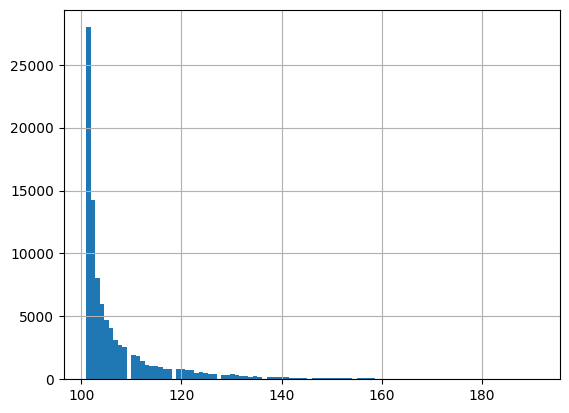

In [29]:
# Найдем кол-во дней от прекращения транзакций до времени отчета
tran_feats['days_last_tran'].hist(bins=100)

In [30]:
train_full = tran_feats.merge(train, on='user_id', how='left')
train_full['td'] = -1 * (train_full['days_last_tran'] - train_full['time']) / train_full['days_last_tran']

array([[<Axes: title={'center': 'days_last_tran'}>,
        <Axes: title={'center': 'time'}>]], dtype=object)

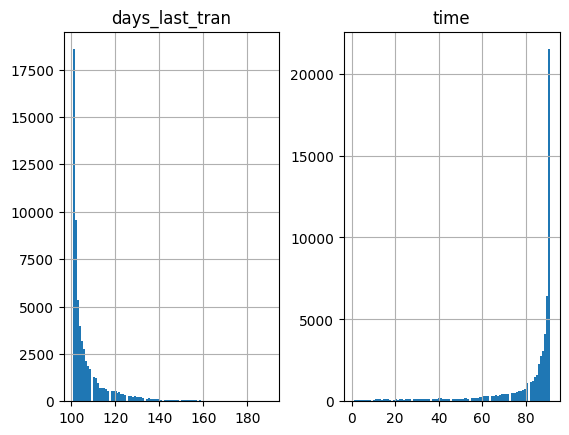

In [31]:
train_full[~train_full.target.isna()][['days_last_tran', 'time']].hist(bins=100)

In [32]:
train_full[~train_full.target.isna()][['days_last_tran', 'time', 'td']]

,days_last_tran,time,td
0,108,77.0,-0.287037
2,114,86.0,-0.245614
3,104,89.0,-0.144231
4,103,57.0,-0.446602
5,102,84.0,-0.176471
...,...,...,...
95992,102,91.0,-0.107843
95995,142,75.0,-0.471831
95997,122,91.0,-0.254098
95998,105,29.0,-0.723810


82.28631648741363
43.248496381407044
2.366905809708739


,user_id,last,count,logsumabs_0,logsumabs_1,logsumabs_2,logsumabs_3,^2_logsumabs_0,^2_logsumabs_1,^2_logsumabs_2,^2_logsumabs_3,^3_logsumabs_0,^3_logsumabs_1,^3_logsumabs_2,^3_logsumabs_3,^4_logsumabs_0,^4_logsumabs_1,^4_logsumabs_2,^4_logsumabs_3,^5_logsumabs_0,^5_logsumabs_1,^5_logsumabs_2,^5_logsumabs_3,^6_logsumabs_0,^6_logsumabs_1,^6_logsumabs_2,^6_logsumabs_3,report_dt,report,days_last_tran,target,time,td,mod_time
3,37,2022-08-17 09:52:33,315,0.000000,12.775178,0.0,0.0,0.000000,10.984993,0.0,0.0,0.000000,10.322018,0.0,0.0,0.000000,7.809947,0.0,0.0,0.000000,5.187512,0.0,0.0,0.000000,17.896781,0.0,0.0,2022-11-30 03:00:00,5,104,0.0,89.0,-0.144231,88.0
5,42,2023-03-19 19:49:22,59,0.000000,11.806563,0.0,0.0,0.000000,9.434056,0.0,0.0,0.000000,8.348869,0.0,0.0,0.000000,6.817831,0.0,0.0,0.000000,5.200173,0.0,0.0,0.000000,13.236815,0.0,0.0,2023-06-30 03:00:00,12,102,0.0,84.0,-0.176471,90.0
6,46,2023-02-18 18:32:10,369,0.000000,12.576277,0.0,0.0,0.000000,11.163121,0.0,0.0,0.000000,10.440239,0.0,0.0,0.000000,8.273592,0.0,0.0,0.000000,5.206004,0.0,0.0,0.000000,17.778739,0.0,0.0,2023-05-31 03:00:00,11,101,0.0,91.0,-0.099010,91.0
7,49,2022-04-19 16:12:15,319,0.000000,13.454894,0.0,0.0,0.000000,11.033320,0.0,0.0,0.000000,10.239509,0.0,0.0,0.000000,8.523970,0.0,0.0,0.000000,5.189269,0.0,0.0,0.000000,17.167941,0.0,0.0,2022-07-31 03:00:00,1,102,0.0,91.0,-0.107843,90.0
8,50,2022-04-14 15:50:08,19,14.983899,9.561899,0.0,0.0,8.099865,5.370362,0.0,0.0,7.033941,5.723785,0.0,0.0,3.044522,-inf,0.0,0.0,5.025586,-0.253206,0.0,0.0,14.808421,7.392587,0.0,0.0,2022-07-31 03:00:00,1,107,0.0,88.0,-0.177570,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95981,560758,2023-03-17 09:51:02,253,0.000000,11.258862,0.0,0.0,0.000000,10.756379,0.0,0.0,0.000000,10.026866,0.0,0.0,0.000000,7.848153,0.0,0.0,0.000000,5.137005,0.0,0.0,0.000000,16.176797,0.0,0.0,2023-06-30 03:00:00,12,104,0.0,88.0,-0.153846,88.0
95983,561018,2023-03-20 13:00:57,415,0.000000,12.304843,0.0,0.0,0.000000,11.325864,0.0,0.0,0.000000,10.454690,0.0,0.0,0.000000,8.894396,0.0,0.0,0.000000,5.203467,0.0,0.0,0.000000,16.817661,0.0,0.0,2023-06-30 03:00:00,12,101,1.0,81.0,-0.198020,91.0
95989,561417,2023-03-10 20:48:00,201,0.000000,13.606960,0.0,0.0,0.000000,10.616645,0.0,0.0,0.000000,9.626020,0.0,0.0,0.000000,8.374477,0.0,0.0,0.000000,5.118963,0.0,0.0,0.000000,18.306714,0.0,0.0,2023-06-30 03:00:00,12,111,0.0,91.0,-0.180180,81.0
95992,561824,2023-03-19 17:10:45,148,0.000000,11.272241,0.0,0.0,0.000000,10.244678,0.0,0.0,0.000000,9.504396,0.0,0.0,0.000000,7.800982,0.0,0.0,0.000000,5.183696,0.0,0.0,0.000000,15.637882,0.0,0.0,2023-06-30 03:00:00,12,102,0.0,91.0,-0.107843,90.0


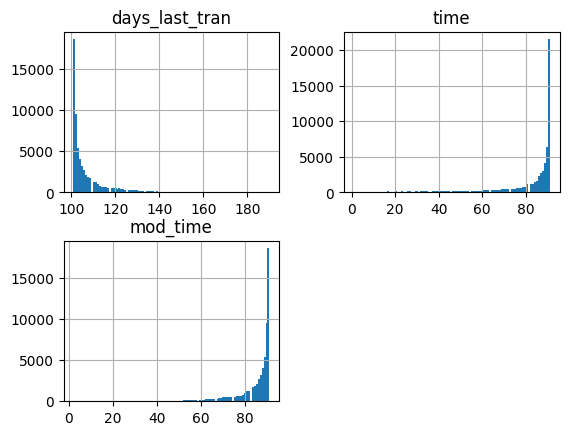

In [33]:
tmp0 = train_full[~train_full.target.isna()].copy()

# tmp.days_last_tran.min(), tmp.days_last_tran.max() # 101, 191
# tmp['time'].min(), tmp['time'].max() # 1, 91

def mod_time(x):
    mid = (101 + 191) / 2
    delta = mid - x
    new_x = (x + 2 * delta) - 100
    return new_x
    
tmp0['mod_time'] = tmp0['days_last_tran'].apply(lambda x: mod_time(x))
tmp0[['days_last_tran', 'time', 'mod_time']].hist(bins=100)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(tmp0['time'], tmp0['days_last_tran']))
print(mean_absolute_percentage_error(tmp0['time'], tmp0['mod_time']))
print(mean_absolute_percentage_error(tmp0[abs(tmp0.td > -0.2)]['time'], tmp0[abs(tmp0.td > -0.2)]['mod_time']))
tmp0[tmp0.td > -0.2]

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

tmp = train_full[~train_full.target.isna()].copy()

bins = [el*100 for el in range(0, 6000)]
labels = [el*100 for el in range(1, 6000)]
tmp['bins1'] = pd.cut(tmp['user_id'], bins=bins, labels=labels)
mults1 = tmp.groupby(['bins1'], as_index=False)[['td']].mean().rename(columns={'td': 'mult1'})
tmp = tmp.merge(mults1, how='left', on='bins1')
tmp['pred_time1'] = tmp['days_last_tran'] * tmp['mult1'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time1']))

mults2 = tmp.groupby(['report'], as_index=False)[['td']].mean().rename(columns={'td': 'mult2'})
tmp = tmp.merge(mults2, how='left', on='report')
tmp['pred_time2'] = tmp['days_last_tran'] * tmp['mult2'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time2']))

bins = [el*10 for el in range(0, 300)]
labels = [el*10 for el in range(1, 300)]
tmp['bins3'] = pd.cut(tmp['count'], bins=bins, labels=labels)
mults3 = tmp.groupby(['bins3'], as_index=False)[['td']].mean().rename(columns={'td': 'mult3'})
tmp = tmp.merge(mults3, how='left', on='bins3')
tmp['pred_time3'] = tmp['days_last_tran'] * tmp['mult3'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time3']))

bins = [el*10 for el in range(0, 30)]
labels = [el*10 for el in range(1, 30)]
tmp['bins4'] = pd.cut(tmp['days_last_tran'], bins=bins, labels=labels)
mults4 = tmp.groupby(['bins4'], as_index=False)[['td']].mean().rename(columns={'td': 'mult4'})
tmp = tmp.merge(mults4, how='left', on='bins4')
tmp['pred_time4'] = tmp['days_last_tran'] * tmp['mult4'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time4']))

tmp['avg_mult'] = tmp[['mult1', 'mult3', 'mult4']].mean(axis=1)
tmp['pred_time_avg'] = tmp['days_last_tran'] * tmp['avg_mult'] + tmp['days_last_tran']
print(mean_absolute_percentage_error(tmp['time'], tmp['days_last_tran']))
print(mean_absolute_percentage_error(tmp['time'], tmp['pred_time_avg']))

82.28631648741363
48.73308174682239
82.28631648741363
53.72049941493461
82.28631648741363
49.94288702934951
82.28631648741363
45.4041647276692
82.28631648741363
46.99151699566141


In [35]:
bins = [el*100 for el in range(0, 6000)]
labels = [el*100 for el in range(1, 6000)]
tran_feats['bins1'] = pd.cut(tran_feats['user_id'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults1, how='left', on='bins1')

tran_feats = tran_feats.merge(mults2, how='left', on='report')

bins = [el*10 for el in range(0, 300)]
labels = [el*10 for el in range(1, 300)]
tran_feats['bins3'] = pd.cut(tran_feats['count'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults3, how='left', on='bins3')

bins = [el*10 for el in range(0, 30)]
labels = [el*10 for el in range(1, 30)]
tran_feats['bins4'] = pd.cut(tran_feats['days_last_tran'], bins=bins, labels=labels)
tran_feats = tran_feats.merge(mults4, how='left', on='bins4')

tran_feats.loc[tran_feats.mult1.isna(), 'mult1'] = tran_feats.mult1.mean()
tran_feats.loc[tran_feats.mult3.isna(), 'mult3'] = tran_feats.mult3.mean()
tran_feats.loc[tran_feats.mult4.isna(), 'mult4'] = tran_feats.mult4.mean()

tran_feats['avg_mult'] = tran_feats[['mult1', 'mult3', 'mult4']].mean(axis=1)
tran_feats['pred_time_avg'] = tran_feats['days_last_tran'] * tran_feats['avg_mult'] + tran_feats['days_last_tran']

In [36]:
train_full = tran_feats.merge(train, on='user_id', how='left')
feats = ['count', 'logsumabs_0', 'logsumabs_1',
         'days_last_tran', 'bins1',
         'mult1', 'mult2', 'bins3', 'mult3']
X = train_full[~train_full.target.isna()][feats]
y = train_full[~train_full.target.isna()]['time']

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)

print(reg.score(X,y))
print(mean_absolute_percentage_error(y, reg.predict(X)))

tran_feats['pred_time_lr'] = reg.predict(train_full[feats])

0.17710929673800158
40.86547844944427


In [37]:
tmp2 = tran_feats.loc[tran_feats.user_id.isin(train.user_id)]
print(mean_absolute_percentage_error(tmp0['time'], (tmp0['mod_time'] + tmp2['pred_time_lr'])/2))

41.50159202460348


In [38]:
tran_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
# tran_feats.fillna(0, inplace=True)

tran_feats = tran_feats[['user_id']+[el for el in tran_feats.columns if '^' in el]]

In [39]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['last', 'count',
                     'bins1', 'mult1', 'mult2', 'bins3', 'mult3', 'days_last_tran',
                     'bins4', 'mult4', 'avg_mult', 'pred_time_avg', 'pred_time_lr']
main_3 = tran_feats[[el for el in tran_feats.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_3_cat_cols = []
main_3_num_cols = []
for col in main_3.columns:
    if col not in ['user_id', 'target']:
        if main_3[col].nunique() < 90:
            main_3_cat_cols.append(col)
        else:
            main_3_num_cols.append(col)
main_3

,user_id,^2_logsumabs_0,^2_logsumabs_1,^2_logsumabs_2,^2_logsumabs_3,^3_logsumabs_0,^3_logsumabs_1,^3_logsumabs_2,^3_logsumabs_3,^4_logsumabs_0,^4_logsumabs_1,^4_logsumabs_2,^4_logsumabs_3,^5_logsumabs_0,^5_logsumabs_1,^5_logsumabs_2,^5_logsumabs_3,^6_logsumabs_0,^6_logsumabs_1,^6_logsumabs_2,^6_logsumabs_3
0,3,0.000000,7.444279,0.0,0.0,0.000000,6.478173,0.0,0.0,0.000000,4.356709,0.0,0.0,0.000000,4.666802,0.0,0.0,0.000000,13.957582,0.0,0.0
1,9,0.000000,9.791357,0.0,0.0,0.000000,8.941719,0.0,0.0,0.000000,7.321189,0.0,0.0,0.000000,5.200140,0.0,0.0,0.000000,16.133648,0.0,0.0
2,13,5.610533,8.338774,0.0,0.0,2.232842,7.468503,0.0,0.0,1.098612,4.844187,0.0,0.0,2.232842,5.069106,0.0,0.0,12.385567,15.000664,0.0,0.0
3,37,0.000000,10.984993,0.0,0.0,0.000000,10.322018,0.0,0.0,0.000000,7.809947,0.0,0.0,0.000000,5.187512,0.0,0.0,0.000000,17.896781,0.0,0.0
4,41,0.000000,7.912791,0.0,0.0,0.000000,7.223670,0.0,0.0,0.000000,6.274762,0.0,0.0,0.000000,5.031791,0.0,0.0,0.000000,13.857930,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,0.000000,9.027808,0.0,0.0,0.000000,7.334710,0.0,0.0,0.000000,5.953243,0.0,0.0,0.000000,4.818061,0.0,0.0,0.000000,13.583983,0.0,0.0
95996,562205,0.000000,10.255356,0.0,0.0,0.000000,9.540063,0.0,0.0,0.000000,7.990915,0.0,0.0,0.000000,5.183748,0.0,0.0,0.000000,14.672142,0.0,0.0
95997,562312,0.000000,9.373292,0.0,0.0,0.000000,8.274834,0.0,0.0,0.000000,7.922986,0.0,0.0,0.000000,5.062487,0.0,0.0,0.000000,13.199449,0.0,0.0
95998,562721,0.000000,9.795333,0.0,0.0,0.000000,8.686993,0.0,0.0,0.000000,6.086775,0.0,0.0,0.000000,5.164125,0.0,0.0,0.000000,15.531544,0.0,0.0


In [40]:
main_3_cat_cols, main_3_num_cols

(['^4_logsumabs_2', '^4_logsumabs_3'],
 ['^2_logsumabs_0',
  '^2_logsumabs_1',
  '^2_logsumabs_2',
  '^2_logsumabs_3',
  '^3_logsumabs_0',
  '^3_logsumabs_1',
  '^3_logsumabs_2',
  '^3_logsumabs_3',
  '^4_logsumabs_0',
  '^4_logsumabs_1',
  '^5_logsumabs_0',
  '^5_logsumabs_1',
  '^5_logsumabs_2',
  '^5_logsumabs_3',
  '^6_logsumabs_0',
  '^6_logsumabs_1',
  '^6_logsumabs_2',
  '^6_logsumabs_3'])

#### Features 4

Бейзлайн 3

In [41]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

# transactions = transactions.merge(currency_mult, how='left')
# transactions.transaction_amt = transactions.transaction_amt * transactions.mult
# transactions.drop(columns=['mult'], inplace=True)


# Объединим всех юзеров в 1 датафрейм, для создания фичей
sample = sample_submit_naive.copy().drop('predict', axis=1)
sample['target'] = -1
main = pd.concat([train, sample])

transactions = transactions.sort_values('transaction_dttm').reset_index(drop=True)

In [42]:
# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)

In [43]:
# Добавим информацию о клиенте, а также закодируем employee_count_nm

main = main.merge(clients, how='left', on='user_id')
main['employee_count_nm'] = LabelEncoder().fit_transform(main['employee_count_nm'].fillna('unknown'))

In [44]:
# Для категорий, которые встречались больше 10 раз агрегируем информацию о транзакциях по пользователю и коду MCC

# good_codes = transactions['mcc_code'].value_counts()
# good_codes = good_codes[good_codes >= 10]

good_codes = transactions.groupby(['mcc_code'], as_index=False)[['user_id']].count()
good_codes = good_codes[good_codes.user_id >= 5000].mcc_code.values

mcc_info = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['count', 'median', 'sum']
).fillna(0)
mcc_info.columns = ['main_' + '_'.join(map(str, x)) for x in mcc_info.columns]

mcc_info_2 = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['^2_transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['median', 'sum']
).fillna(0)
mcc_info_2.columns = ['^2_main_' + '_'.join(map(str, x)) for x in mcc_info_2.columns]

mcc_info_3 = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['^3_transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['median', 'sum']
).fillna(0)
mcc_info_3.columns = ['^3_main_' + '_'.join(map(str, x)) for x in mcc_info_3.columns]

mcc_info_4 = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['^4_transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['median', 'sum']
).fillna(0)
mcc_info_4.columns = ['^4_main_' + '_'.join(map(str, x)) for x in mcc_info_4.columns]

mcc_info_5 = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['^5_transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['median', 'sum']
).fillna(0)
mcc_info_5.columns = ['^5_main_' + '_'.join(map(str, x)) for x in mcc_info_5.columns]

mcc_info_6 = transactions[transactions.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['^6_transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['median', 'sum']
).fillna(0)
mcc_info_6.columns = ['^6_main_' + '_'.join(map(str, x)) for x in mcc_info_6.columns]


count_cols = [x for x in mcc_info.columns if 'count' in x]
mcc_info['sum'] = mcc_info[count_cols].sum(axis=1)
for col in count_cols:
    mcc_info[f'{col}_norm'] = mcc_info[col] / mcc_info['sum']
mcc_info.drop('sum', axis=1, inplace=True)

main = main.merge(mcc_info, how='left', left_on='user_id', right_index=True)
main = main.merge(mcc_info_2, how='left', left_on='user_id', right_index=True)
main = main.merge(mcc_info_3, how='left', left_on='user_id', right_index=True)
main = main.merge(mcc_info_4, how='left', left_on='user_id', right_index=True)
main = main.merge(mcc_info_5, how='left', left_on='user_id', right_index=True)
main = main.merge(mcc_info_6, how='left', left_on='user_id', right_index=True)

In [45]:
# pivot_table по валютам со сбором базовой информации

currency_pivot = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='transaction_amt',
    aggfunc=['min', 'max', 'median', 'count', 'std']
).fillna(0)
currency_pivot.columns = [f'currency_{x[0]}_{x[1]}' for x in currency_pivot.columns]

currency_pivot_2 = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='^2_transaction_amt',
    aggfunc=['min', 'max', 'median', 'std']
).fillna(0)
currency_pivot_2.columns = [f'^2_currency_{x[0]}_{x[1]}' for x in currency_pivot_2.columns]

currency_pivot_3 = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='^3_transaction_amt',
    aggfunc=['min', 'max', 'median', 'std']
).fillna(0)
currency_pivot_3.columns = [f'^3_currency_{x[0]}_{x[1]}' for x in currency_pivot_3.columns]

currency_pivot_4 = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='^4_transaction_amt',
    aggfunc=['min', 'max', 'median', 'std']
).fillna(0)
currency_pivot_4.columns = [f'^4_currency_{x[0]}_{x[1]}' for x in currency_pivot_4.columns]

currency_pivot_5 = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='^5_transaction_amt',
    aggfunc=['min', 'max', 'median', 'std']
).fillna(0)
currency_pivot_5.columns = [f'^5_currency_{x[0]}_{x[1]}' for x in currency_pivot_5.columns]

currency_pivot_6 = transactions.pivot_table(
    index='user_id',
    columns='currency_rk',
    values='^6_transaction_amt',
    aggfunc=['min', 'max', 'median', 'std']
).fillna(0)
currency_pivot_6.columns = [f'^6_currency_{x[0]}_{x[1]}' for x in currency_pivot_6.columns]

# Сборка нормированных значений о том в каких валютах были транзации у клиента
currency_pivot['sum'] = currency_pivot[[f'currency_count_{x}' for x in range(4)]].sum(axis=1)
for x in range(4):
    currency_pivot[f'currency_count_{x}_norm'] = currency_pivot[f'currency_count_{x}'] / currency_pivot['sum']
currency_pivot.drop('sum', axis=1, inplace=True)

main = main.merge(currency_pivot, how='left', left_on='user_id', right_index=True)
main = main.merge(currency_pivot_2, how='left', left_on='user_id', right_index=True)
main = main.merge(currency_pivot_3, how='left', left_on='user_id', right_index=True)
main = main.merge(currency_pivot_4, how='left', left_on='user_id', right_index=True)
main = main.merge(currency_pivot_5, how='left', left_on='user_id', right_index=True)
main = main.merge(currency_pivot_6, how='left', left_on='user_id', right_index=True)

In [46]:
# Сбор информации о транзакциях в каждой валюте за последние 30 дней, а также за весь промежуток

df_more = transactions.merge(clients[['user_id', 'report']], how='left', on='user_id')
df_more = df_more.merge(report_dates, how='left', on='report')
df_more['days_to_report'] = (df_more['report_dt'] - df_more['transaction_dttm']).dt.days


for day_diff in [30, 1000]:

    # Информация о размерах транзакций в различных валютах
    currency_pivot = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='transaction_amt',
        aggfunc=['sum', 'mean', 'median', 'count']
    ).fillna(0)
    currency_pivot.columns = [f'currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot.columns]
    
    currency_pivot_2 = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='^2_transaction_amt',
        aggfunc=['sum', 'mean', 'median']
    ).fillna(0)
    currency_pivot_2.columns = [f'^2_currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot_2.columns]
    
    currency_pivot_3 = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='^3_transaction_amt',
        aggfunc=['sum', 'mean', 'median']
    ).fillna(0)
    currency_pivot_3.columns = [f'^3_currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot_3.columns]
    
    currency_pivot_4 = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='^4_transaction_amt',
        aggfunc=['sum', 'mean', 'median']
    ).fillna(0)
    currency_pivot_4.columns = [f'^4_currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot_4.columns]
    
    currency_pivot_5 = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='^5_transaction_amt',
        aggfunc=['sum', 'mean', 'median']
    ).fillna(0)
    currency_pivot_5.columns = [f'^5_currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot_5.columns]
    
    currency_pivot_6 = df_more[df_more['days_to_report'] < day_diff + 100].pivot_table(
        index='user_id',
        columns='currency_rk',
        values='^6_transaction_amt',
        aggfunc=['sum', 'mean', 'median']
    ).fillna(0)
    currency_pivot_6.columns = [f'^6_currency_daydiff_{day_diff}_{x[0]}_{x[1]}' for x in currency_pivot_6.columns]

    currency_pivot['sum'] = currency_pivot[[x for x in currency_pivot.columns if 'count' in x]].sum(axis=1)
    for x in range(4):
        currency_pivot[f'currency_daydiff_{day_diff}_count_{x}_norm'] = currency_pivot[f'currency_daydiff_{day_diff}_count_{x}'] / currency_pivot['sum']
    currency_pivot.drop('sum', axis=1, inplace=True)

    main = main.merge(currency_pivot, how='left', left_on='user_id', right_index=True)
    main = main.merge(currency_pivot_2, how='left', left_on='user_id', right_index=True)
    main = main.merge(currency_pivot_3, how='left', left_on='user_id', right_index=True)
    main = main.merge(currency_pivot_4, how='left', left_on='user_id', right_index=True)
    main = main.merge(currency_pivot_5, how='left', left_on='user_id', right_index=True)
    main = main.merge(currency_pivot_6, how='left', left_on='user_id', right_index=True)


    general_trans_info = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_2 = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['^2_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_2[['sum']] = general_trans_info_2[['sum']].fillna(0)
    general_trans_info_2.columns = [f'^2_general_trans_info_{day_diff}_{x}' for x in general_trans_info_2]
    main = main.merge(general_trans_info_2, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_3 = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['^3_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_3[['sum']] = general_trans_info_3[['sum']].fillna(0)
    general_trans_info_3.columns = [f'^3_general_trans_info_{day_diff}_{x}' for x in general_trans_info_3]
    main = main.merge(general_trans_info_3, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_4 = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['^4_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_4[['sum']] = general_trans_info_4[['sum']].fillna(0)
    general_trans_info_4.columns = [f'^4_general_trans_info_{day_diff}_{x}' for x in general_trans_info_4]
    main = main.merge(general_trans_info_4, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_5 = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['^5_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_5[['sum']] = general_trans_info_5[['sum']].fillna(0)
    general_trans_info_5.columns = [f'^5_general_trans_info_{day_diff}_{x}' for x in general_trans_info_5]
    main = main.merge(general_trans_info_5, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_6 = df_more[df_more['days_to_report'] < day_diff + 100].groupby('user_id')['^6_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_6[['sum']] = general_trans_info_6[['sum']].fillna(0)
    general_trans_info_6.columns = [f'^6_general_trans_info_{day_diff}_{x}' for x in general_trans_info_6]
    main = main.merge(general_trans_info_6, how='left', left_on='user_id', right_index=True)

    general_trans_info = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['transaction_amt']>0)].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_2 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^2_transaction_amt']>0)].groupby('user_id')['^2_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_2[['sum']] = general_trans_info_2[['sum']].fillna(0)
    general_trans_info_2.columns = [f'^2_positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info_2]
    main = main.merge(general_trans_info_2, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_3 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^3_transaction_amt']>0)].groupby('user_id')['^3_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_3[['sum']] = general_trans_info_3[['sum']].fillna(0)
    general_trans_info_3.columns = [f'^3_positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info_3]
    main = main.merge(general_trans_info_3, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_4 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^4_transaction_amt']>0)].groupby('user_id')['^4_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_4[['sum']] = general_trans_info_4[['sum']].fillna(0)
    general_trans_info_4.columns = [f'^4_positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info_4]
    main = main.merge(general_trans_info_4, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_5 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^5_transaction_amt']>0)].groupby('user_id')['^5_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_5[['sum']] = general_trans_info_5[['sum']].fillna(0)
    general_trans_info_5.columns = [f'^5_positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info_5]
    main = main.merge(general_trans_info_5, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_6 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^6_transaction_amt']>0)].groupby('user_id')['^6_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_6[['sum']] = general_trans_info_6[['sum']].fillna(0)
    general_trans_info_6.columns = [f'^6_positive_general_trans_info_{day_diff}_{x}' for x in general_trans_info_6]
    main = main.merge(general_trans_info_6, how='left', left_on='user_id', right_index=True)

    general_trans_info = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['transaction_amt']<0)].groupby('user_id')['transaction_amt'].agg(['sum', 'count', 'median'])
    general_trans_info[['sum', 'count']] = general_trans_info[['sum', 'count']].fillna(0)
    general_trans_info.columns = [f'negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info]
    main = main.merge(general_trans_info, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_2 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^2_transaction_amt']<0)].groupby('user_id')['^2_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_2[['sum']] = general_trans_info_2[['sum']].fillna(0)
    general_trans_info_2.columns = [f'^2_negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info_2]
    main = main.merge(general_trans_info_2, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_3 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^3_transaction_amt']<0)].groupby('user_id')['^3_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_3[['sum']] = general_trans_info_3[['sum']].fillna(0)
    general_trans_info_3.columns = [f'^3_negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info_3]
    main = main.merge(general_trans_info_3, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_4 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^4_transaction_amt']<0)].groupby('user_id')['^4_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_4[['sum']] = general_trans_info_4[['sum']].fillna(0)
    general_trans_info_4.columns = [f'^4_negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info_4]
    main = main.merge(general_trans_info_4, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_5 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^5_transaction_amt']<0)].groupby('user_id')['^5_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_5[['sum']] = general_trans_info_5[['sum']].fillna(0)
    general_trans_info_5.columns = [f'^5_negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info_5]
    main = main.merge(general_trans_info_5, how='left', left_on='user_id', right_index=True)
    
    general_trans_info_6 = df_more[(df_more['days_to_report']<day_diff + 100)&(df_more['^6_transaction_amt']<0)].groupby('user_id')['^6_transaction_amt'].agg(['sum', 'median'])
    general_trans_info_6[['sum']] = general_trans_info_6[['sum']].fillna(0)
    general_trans_info_6.columns = [f'^6_negative_general_trans_info_{day_diff}_{x}' for x in general_trans_info_6]
    main = main.merge(general_trans_info_6, how='left', left_on='user_id', right_index=True)


# Анализируем кол-во транзакций в последние n дней / кол-во транзакций до последних n дней
for x in [5, 30]:
    prev = df_more[df_more['days_to_report'] > x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{x}_days'}, axis=1)
    last = df_more[df_more['days_to_report'] <= x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_last_{x}_days'}, axis=1)

    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(last, how='left', on='user_id')
    main[f'num_transaction_last_{x}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_{x}_days'].fillna(0, inplace=True)
    main[f'percent_last_{x}'] = main[f'num_transaction_last_{x}_days'] / main[f'num_transaction_before_{x}_days']
    
# percent_last_30 хорошо себя показывает, поэтому делаем аналоги

for x in [10, 15, 20, 25, 45, 60, 90, 120, 150, 180]:
    prev = df_more[df_more['days_to_report'] > x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{x}_days'}, axis=1)
    last = df_more[df_more['days_to_report'] <= x + 100].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_last_{x}_days'}, axis=1)

    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(last, how='left', on='user_id')
    main[f'num_transaction_last_{x}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_{x}_days'].fillna(0, inplace=True)
    main[f'percent_last_{x}'] = main[f'num_transaction_last_{x}_days'] / main[f'num_transaction_before_{x}_days']
    main.drop([f'num_transaction_last_{x}_days', f'num_transaction_before_{x}_days'], axis=1, inplace=True)
    
xs = [0, 15, 30, 45, 60, 90, 120, 150, 180]
for ind in range(6):
    prev = df_more[(df_more['days_to_report'] > xs[ind] + 100) & (df_more['days_to_report'] <= xs[ind+1] + 100)].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days'}, axis=1)
    prev_prev = df_more[(df_more['days_to_report'] > xs[ind+1] + 100) & (df_more['days_to_report'] <= xs[ind+2] + 100)].groupby('user_id')['report'].agg(['count']).reset_index().rename({'count': f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'}, axis=1)
    main = main.merge(prev, how='left', on='user_id')
    main = main.merge(prev_prev, how='left', on='user_id')
    main[f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days'].fillna(0, inplace=True)
    main[f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'].fillna(0, inplace=True)
    main[f'percent_last_{xs[ind]}_{xs[ind+1]}'] = main[f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'] / main[f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days']
    main.drop([f'num_transaction_before_{xs[ind]}_{xs[ind+1]}_days', f'num_transaction_before_before_{xs[ind+1]}_{xs[ind+2]}_days'], axis=1, inplace=True)

In [47]:
main.shape

(96000, 1827)

In [48]:
# Кол-во уникальных MCC кодов, валют, а также уникальных дней, в которые были транзакции
main = main.merge(df_more.groupby('user_id')['days_to_report'].nunique(), how='left', on='user_id').rename({'days_to_report': 'nunique_days'}, axis=1)
main = main.merge(df_more.groupby('user_id')['mcc_code'].nunique(), how='left', on='user_id').rename({'mcc_code': 'nunique_mcc_codes'}, axis=1)
main = main.merge(df_more.groupby('user_id')['currency_rk'].nunique(), how='left', on='user_id').rename({'currency_rk': 'nunique_currency'}, axis=1)

In [49]:
# Информация о количестве и размере транзакций в разрезе часов.

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='transaction_amt',
    aggfunc=['count', 'median']
).fillna(0)
pivot_table.columns = [f'hour_{x[0]}_{x[1]}' for x in pivot_table.columns]

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table_2 = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='^2_transaction_amt',
    aggfunc=['median']
).fillna(0)
pivot_table_2.columns = [f'^2_hour_{x[0]}_{x[1]}' for x in pivot_table_2.columns]

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table_3 = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='^3_transaction_amt',
    aggfunc=['median']
).fillna(0)
pivot_table_3.columns = [f'^3_hour_{x[0]}_{x[1]}' for x in pivot_table_3.columns]

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table_4 = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='^4_transaction_amt',
    aggfunc=['median']
).fillna(0)
pivot_table_4.columns = [f'^4_hour_{x[0]}_{x[1]}' for x in pivot_table_4.columns]

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table_5 = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='^5_transaction_amt',
    aggfunc=['median']
).fillna(0)
pivot_table_5.columns = [f'^5_hour_{x[0]}_{x[1]}' for x in pivot_table_5.columns]

tmp = transactions.copy()
tmp['hour'] = tmp['transaction_dttm'].dt.hour
pivot_table_6 = tmp.pivot_table(
    index='user_id',
    columns='hour',
    values='^6_transaction_amt',
    aggfunc=['median']
).fillna(0)
pivot_table_6.columns = [f'^6_hour_{x[0]}_{x[1]}' for x in pivot_table_6.columns]

count_cols = [x for x in pivot_table.columns if 'count' in x]
pivot_table['sum'] = pivot_table[count_cols].sum(axis=1)
for col in count_cols:
    pivot_table[f'{col}_norm'] = pivot_table[col] / pivot_table['sum']
pivot_table.drop('sum', axis=1, inplace=True)

main = main.merge(pivot_table, how='left', left_on='user_id', right_index=True)
main = main.merge(pivot_table_2, how='left', left_on='user_id', right_index=True)
main = main.merge(pivot_table_3, how='left', left_on='user_id', right_index=True)
main = main.merge(pivot_table_4, how='left', left_on='user_id', right_index=True)
main = main.merge(pivot_table_5, how='left', left_on='user_id', right_index=True)
main = main.merge(pivot_table_6, how='left', left_on='user_id', right_index=True)

In [50]:
# Фичи, основанные на временных отрезках

cur = transactions.groupby('user_id')['transaction_dttm'].agg(['min', 'max']).reset_index()
cur = cur.merge(clients[['user_id', 'report']], how='left', on='user_id')
cur = cur.merge(report_dates, how='left', on='report')

cur['min_diff_dttm'] = (cur['report_dt'] - cur['min']).dt.days
cur['days_to_report'] = (cur['report_dt'] - cur['max']).dt.days
cur['max_min_diff_dttm'] = cur['days_to_report'] - cur['min_diff_dttm']

main = main.merge(cur[['user_id', 'min_diff_dttm','days_to_report','max_min_diff_dttm']], how='left', on='user_id')


main['transaction_density'] = main['max_min_diff_dttm'] / main['general_trans_info_1000_count']
main['days_density'] = (main['max_min_diff_dttm'] + 1) / main['nunique_days']

In [52]:
main.replace([np.inf, -np.inf], np.nan, inplace=True)
main.fillna(0, inplace=True)

main = main[['user_id', 'target', 'time']+[el for el in main.columns if '^' in el]]

# cat_cols = ['customer_age', 'employee_count_nm', 'report']
# main[cat_cols] = main[cat_cols].astype(str)

main = main.sort_values('user_id').reset_index(drop=True)

train = main[main.target != -1]
test = main[main.target == -1]

In [53]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,
    
    eval_metric='AUC',
#     cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
# model.fit(train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1), train['target'], verbose=100)
# model.fit(train.drop(['user_id', 'target', 'time']+cat_cols, axis=1), train['target'], verbose=100)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1).columns,
#     'name': train.drop(['user_id', 'target', 'time']+cat_cols, axis=1).columns,
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

display(df_imp) # Можно посмотреть на предварительный feature_importance()

df_imp = df_imp[df_imp['imp'] > 0.5] # Берем все фичи, у которых важность больше 0.3

# Добавляем статистические фичи, их нельзя было использовать для тренировки здесь, т.к. получился бы лик в данных
# good_cols = df_imp['name'].tolist() + ['group_employee_age_mean', 'group_report_age_mean']
good_cols = df_imp['name'].tolist()

TBB Warning: The number of workers is currently limited to 3. The request for 5 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	total: 311ms	remaining: 7m 15s
100:	total: 24s	remaining: 5m 8s
200:	total: 49.1s	remaining: 4m 52s
300:	total: 1m 11s	remaining: 4m 20s
400:	total: 1m 32s	remaining: 3m 51s
500:	total: 1m 53s	remaining: 3m 23s
600:	total: 2m 13s	remaining: 2m 57s
700:	total: 2m 32s	remaining: 2m 32s
800:	total: 2m 52s	remaining: 2m 8s
900:	total: 3m 11s	remaining: 1m 46s
1000:	total: 3m 31s	remaining: 1m 24s
1100:	total: 3m 51s	remaining: 1m 2s
1200:	total: 4m 11s	remaining: 41.7s
1300:	total: 4m 32s	remaining: 20.7s
1399:	total: 4m 51s	remaining: 0us


,name,imp
1117,^6_currency_std_1,7.388567
104,^2_main_sum_^2_transaction_amt_0,1.561925
1085,^4_currency_std_1,1.437477
1053,^2_currency_std_1,1.387058
1041,^2_currency_min_1,1.301626
...,...,...
246,^3_main_median_^3_transaction_amt_40,0.000000
245,^3_main_median_^3_transaction_amt_39,0.000000
1051,^2_currency_median_3,0.000000
1050,^2_currency_median_2,0.000000


In [54]:
metrics.roc_auc_score(train['target'], model.predict_proba(train.drop(['user_id', 'target', 'time'], axis=1))[:, 1])

0.8402182134711172

In [55]:
print(len(good_cols))
df_imp

34


,name,imp
1117,^6_currency_std_1,7.388567
104,^2_main_sum_^2_transaction_amt_0,1.561925
1085,^4_currency_std_1,1.437477
1053,^2_currency_std_1,1.387058
1041,^2_currency_min_1,1.301626
1069,^3_currency_std_1,1.250231
1239,^4_currency_daydiff_1000_mean_1,1.207529
1277,^5_general_trans_info_1000_median,1.203167
755,^5_main_sum_^5_transaction_amt_28,1.048038
1093,^5_currency_max_1,0.914803


In [56]:
new_main = main[['user_id']+good_cols].copy()

In [57]:
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['last', 'count', 'target', 'time']
main_4 = new_main[[el for el in new_main.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_4_cat_cols = []
main_4_num_cols = []
for col in main_4.columns:
    if col not in ['user_id', 'target', 'time']:
        if False:
            main_4_cat_cols.append(col)
        else:
            main_4_num_cols.append(col)
            
main_4.replace([np.inf, -np.inf], np.nan, inplace=True)
main_4.fillna(0, inplace=True)
main_4

,user_id,^6_currency_std_1,^2_main_sum_^2_transaction_amt_0,^4_currency_std_1,^2_currency_std_1,^2_currency_min_1,^3_currency_std_1,^4_currency_daydiff_1000_mean_1,^5_general_trans_info_1000_median,^5_main_sum_^5_transaction_amt_28,^5_currency_max_1,^3_main_sum_^3_transaction_amt_12,^6_positive_general_trans_info_1000_median,^5_main_median_^5_transaction_amt_0,^5_hour_median_3,^5_currency_daydiff_30_sum_1,^5_currency_daydiff_1000_median_1,^5_positive_general_trans_info_1000_median,^2_currency_daydiff_30_mean_1,^3_currency_daydiff_1000_mean_1,^5_currency_median_1,^5_positive_general_trans_info_1000_sum,^5_hour_median_2,^4_main_sum_^4_transaction_amt_12,^4_currency_max_1,^6_main_sum_^6_transaction_amt_12,^5_main_median_^5_transaction_amt_51,^2_general_trans_info_1000_sum,^6_currency_daydiff_30_median_1,^5_currency_daydiff_1000_mean_1,^6_currency_daydiff_1000_median_1,^5_general_trans_info_1000_sum,^6_currency_daydiff_30_mean_1,^3_main_median_^3_transaction_amt_51,^5_main_sum_^5_transaction_amt_12
0,3,73592.880394,911.039306,16.902394,40.687321,108.264062,40.687321,7.090909,6.076157,0.000000,30.108970,0.000000,13706.416641,6.076157,0.000000,32.990394,6.076157,7.531788,114.289954,59.161920,6.076157,106.357083,0.000000,0.0,56.0,0.000000,0.0,1710.051481,-92999.043808,9.668826,-124028.156601,106.357083,-74079.956894,0.0,0.00000
1,9,111980.370637,0.000000,26.124249,52.556077,102.289907,52.556077,16.800000,0.906834,0.000000,21.808750,0.000000,0.000000,0.000000,0.000000,43.226030,0.906834,0.914329,119.036894,84.936935,0.906834,181.297581,0.000000,0.0,189.0,0.000000,0.0,17878.549850,-311560.349049,2.014418,-62907.806572,181.297581,-313022.029991,0.0,0.00000
2,13,35326.932531,0.000000,4.140968,50.223585,114.257708,50.223585,6.047619,6.785926,0.000000,21.620289,492.533461,0.000000,0.000000,12.594352,23.663993,5.478727,8.093125,115.279560,83.427682,5.478727,168.358495,8.750046,72.0,12.0,-432514.065186,0.0,4456.248819,-116520.282471,7.572960,-85346.131348,168.358495,-116520.282471,0.0,44.95037
3,37,83829.483724,365.879282,19.386892,46.110445,104.713507,46.110445,7.825397,0.203333,2.317963,6.925602,0.000000,0.000000,0.127801,0.490689,26.053877,0.203333,0.203953,121.672735,96.490603,0.203333,179.022535,1.370266,0.0,155.0,0.000000,0.0,58982.313275,-298549.420931,0.568326,-196538.949532,179.022535,-304818.425548,0.0,0.00000
4,41,29998.434867,0.000000,38.136979,43.762566,103.262766,43.762566,33.187500,2.163791,0.000000,31.168206,0.000000,0.000000,0.000000,0.000000,32.095451,2.163791,2.308715,104.417124,85.719540,2.163791,153.207130,0.000000,0.0,86.0,0.000000,0.0,2732.005694,-105473.461578,9.575446,-68169.943481,153.207130,-105473.461578,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,5474.347095,0.000000,20.068576,19.736875,142.873935,19.736875,10.405405,0.860012,0.000000,53.427824,0.000000,0.000000,0.000000,0.000000,0.000000,0.860012,0.865573,0.000000,41.421159,0.860012,123.724942,0.000000,0.0,113.0,0.000000,0.0,8331.575579,0.000000,3.343917,-21293.860950,123.724942,0.000000,0.0,0.00000
95996,562205,10521.509512,5045.848044,40.390193,49.396821,102.048947,49.396821,19.562914,0.662523,0.000000,8.054167,0.000000,1061.166979,1.220341,0.761840,29.241713,0.662523,0.667297,117.280273,92.091572,0.662523,178.350035,0.000000,0.0,155.0,0.000000,0.0,28434.418819,-31699.205721,1.181126,-15432.580589,178.350035,-32265.954670,0.0,0.00000
95997,562312,5284.013391,0.000000,70.511047,49.581105,122.261134,49.581105,49.285714,1.030017,0.000000,37.073229,0.000000,0.000000,0.000000,9.225845,12.864676,1.030017,1.038924,125.846130,70.069111,1.030017,157.983009,3.074913,0.0,155.0,0.000000,0.0,11769.801817,-17051.953167,2.821125,-9666.475788,157.983009,-17283.625756,0.0,0.00000
95998,562721,47177.348455,4061.892951,8.616397,42.024891,105.999363,42.024891,5.176471,0.822164,0.000000,25.439109,0.000000,543.884258,1.255532,0.963970,27.014039,0.822164,0.845

In [58]:
main_4_cat_cols, len(main_4_num_cols)

([], 34)

#### Features 5

Всякие доп фичи похожие на фичи с высокой важностью и доп идеи от ChatGPT

In [59]:
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

transactions = transactions.merge(currency_mult, how='left')
transactions.transaction_amt = transactions.transaction_amt * transactions.mult
transactions.drop(columns=['mult'], inplace=True)

clients = merge_by_concat(clients, report_dates, ['report'])
transactions = merge_by_concat(transactions, clients[['user_id','report_dt']], ['user_id'])

transactions['days_since_transaction'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.days

In [60]:
# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)

In [61]:
main = clients.copy()

xs = [0, 15, 30, 45, 60, 90]
for ind in range(4):
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_2 = sl1.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^2_trans_amt_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^2_trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_2 = sl2.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^2_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^2_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_3 = sl1.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^3_trans_amt_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^3_trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_3 = sl2.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^3_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^3_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_4 = sl1.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^4_trans_amt_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^4_trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_4 = sl2.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^4_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^4_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_5 = sl1.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^5_trans_amt_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^5_trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_5 = sl2.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^5_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^5_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_6 = sl1.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^6_trans_amt_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^6_trans_amt_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_6 = sl2.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^6_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^6_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    main = main.merge(gr1_2, how='left')
    main = main.merge(gr2_2, how='left')
    main = main.merge(gr1_3, how='left')
    main = main.merge(gr2_3, how='left')
    main = main.merge(gr1_4, how='left')
    main = main.merge(gr2_4, how='left')
    main = main.merge(gr1_5, how='left')
    main = main.merge(gr2_5, how='left')
    main = main.merge(gr1_6, how='left')
    main = main.merge(gr2_6, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    
    main[f'^2_trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_median_{xs[ind]}_{xs[ind+1]}']
    
    main.drop([f'trans_amt_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^2_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^3_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^4_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^5_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^6_trans_amt_sum_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_mean_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    
    
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) & (transactions.transaction_amt>0) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) & (transactions.transaction_amt>0) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    
    gr1_2 = sl1.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^2_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^2_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_2 = sl2.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^2_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^2_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_3 = sl1.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^3_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^3_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_3 = sl2.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^3_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^3_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_4 = sl1.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^4_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^4_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_4 = sl2.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^4_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^4_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_5 = sl1.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^5_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^5_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_5 = sl2.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^5_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^5_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_6 = sl1.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'mean': f'^6_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}',
                                                                                                                                       'median': f'^6_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_6 = sl2.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'mean': f'^6_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}',
                                                                                                                                       'median': f'^6_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    main = main.merge(gr1_2, how='left')
    main = main.merge(gr2_2, how='left')
    main = main.merge(gr1_3, how='left')
    main = main.merge(gr2_3, how='left')
    main = main.merge(gr1_4, how='left')
    main = main.merge(gr2_4, how='left')
    main = main.merge(gr1_5, how='left')
    main = main.merge(gr2_5, how='left')
    main = main.merge(gr1_6, how='left')
    main = main.merge(gr2_6, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    
    main[f'^2_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_pos_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_pos_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_pos_median_{xs[ind]}_{xs[ind+1]}']
    
    main.drop([f'trans_amt_pos_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^2_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^3_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^4_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^5_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^6_trans_amt_pos_sum_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_pos_mean_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_pos_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)

    
    sl1 = transactions[(transactions.days_since_transaction > xs[ind] + 100) & (transactions.transaction_amt<0) &
                       (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    sl2 = transactions[(transactions.days_since_transaction > xs[ind+1] + 100) & (transactions.transaction_amt<0) &
                       (transactions.days_since_transaction <= xs[ind+2] + 100)].copy()
    gr1 = sl1.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}', 'sum': f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 'mean': f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2 = sl2.groupby('user_id', as_index=False)['transaction_amt'].agg(['count', 'sum', 'mean', 'median']).reset_index(drop=True).rename({'count': f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}', 'sum': f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 'mean': f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 'median': f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    
    gr1_2 = sl1.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'mean': f'^2_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'median': f'^2_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_2 = sl2.groupby('user_id', as_index=False)['^2_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^2_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'mean': f'^2_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'median': f'^2_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_3 = sl1.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'mean': f'^3_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'median': f'^3_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_3 = sl2.groupby('user_id', as_index=False)['^3_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^3_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'mean': f'^3_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'median': f'^3_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_4 = sl1.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'mean': f'^4_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'median': f'^4_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_4 = sl2.groupby('user_id', as_index=False)['^4_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^4_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'mean': f'^4_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'median': f'^4_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_5 = sl1.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'mean': f'^5_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'median': f'^5_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_5 = sl2.groupby('user_id', as_index=False)['^5_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^5_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'mean': f'^5_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'median': f'^5_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    gr1_6 = sl1.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'mean': f'^6_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}', 
                                                                                                                                       'median': f'^6_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    gr2_6 = sl2.groupby('user_id', as_index=False)['^6_transaction_amt'].agg(['sum', 'mean', 'median']).reset_index(drop=True).rename({'sum': f'^6_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'mean': f'^6_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', 
                                                                                                                                       'median': f'^6_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'}, axis=1)
    
    prev_cols = main.columns
    main = main.merge(gr1, how='left')
    main = main.merge(gr2, how='left')
    main = main.merge(gr1_2, how='left')
    main = main.merge(gr2_2, how='left')
    main = main.merge(gr1_3, how='left')
    main = main.merge(gr2_3, how='left')
    main = main.merge(gr1_4, how='left')
    main = main.merge(gr2_4, how='left')
    main = main.merge(gr1_5, how='left')
    main = main.merge(gr2_5, how='left')
    main = main.merge(gr1_6, how='left')
    main = main.merge(gr2_6, how='left')
    new_cols = [el for el in main.columns if el not in prev_cols]
    main[new_cols] = main[new_cols].fillna(0)
    main[f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_count_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    
    main[f'^2_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^2_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^2_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^2_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^3_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^3_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^3_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^4_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^4_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^4_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^5_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^5_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^5_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_neg_sum_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_neg_mean_{xs[ind]}_{xs[ind+1]}']
    main[f'^6_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}_ratio'] = main[f'^6_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'] / main[f'^6_trans_amt_neg_median_{xs[ind]}_{xs[ind+1]}']
    
    main.drop([f'trans_amt_neg_count_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^2_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'^2_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^3_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'^3_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^4_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'^4_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^5_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'^5_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)
    main.drop([f'^6_trans_amt_neg_sum_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_neg_mean_{xs[ind+1]}_{xs[ind+2]}', f'^6_trans_amt_neg_median_{xs[ind+1]}_{xs[ind+2]}'], axis=1, inplace=True)

In [62]:
main.shape

(96000, 462)

In [63]:
# 3. Transaction density
transactions['next_transaction'] = transactions.groupby('user_id')['transaction_dttm'].shift(-1)
transactions['days_to_next_trans'] = (transactions['next_transaction'] - transactions['transaction_dttm']).dt.days
days_between_trans = transactions.groupby('user_id', as_index=False)['days_to_next_trans'].agg(['mean', 'median']).rename({'mean': 'days_between_trans_mean', 'median': 'days_between_trans_median'}, axis=1)
main = main.merge(days_between_trans, how='left')

xs = [0, 15, 30, 45, 60, 90]
for ind in range(5):
    sl = transactions[(transactions.days_since_transaction > xs[ind] + 100) &
                      (transactions.days_since_transaction <= xs[ind+1] + 100)].copy()
    days_between_trans = sl.groupby('user_id', as_index=False)['days_to_next_trans'].agg(['mean', 'median']).rename({'mean': f'days_between_trans_mean_{xs[ind]}_{xs[ind+1]}', 'median': f'days_between_trans_median_{xs[ind]}_{xs[ind+1]}'}, axis=1)
    main = main.merge(days_between_trans, how='left')

In [64]:
transactions['trans_day'] = transactions['transaction_dttm'].dt.date
unique_trans_days = transactions.groupby('user_id', as_index=False)['trans_day'].nunique().rename(columns={'trans_day': 'unique_trans_days'})
main = main.merge(unique_trans_days, how='left')

In [65]:
from sklearn.linear_model import LinearRegression

def calculate_trend(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['transaction_amt'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line

def calculate_trend2(user_group):
    if len(user_group) < 2:  # Need at least two points to calculate a slope
        return 0
    lr = LinearRegression()
    X = np.array(range(len(user_group))).reshape(-1, 1)  # Time in days as X
    y = user_group['days_to_next_trans'].values
    lr.fit(X, y)
    return lr.coef_[0]  # Slope of the trend line

transaction_trends_pos = transactions[transactions.transaction_amt>0].groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend_pos')
transaction_trends_neg = transactions[transactions.transaction_amt<0].groupby('user_id').apply(calculate_trend).reset_index(name='trans_amount_trend_neg')

transactions.days_to_next_trans = transactions.days_to_next_trans.fillna(0)

transaction_trends_dtnt = transactions.groupby('user_id').apply(calculate_trend2).reset_index(name='trans_amount_trend_dtnt')
main = main.merge(transaction_trends_pos, how='left')
main = main.merge(transaction_trends_neg, how='left')
main = main.merge(transaction_trends_dtnt, how='left')

In [66]:
main = main[['user_id']+[el for el in main.columns if '^' in el]]

main.replace([np.inf, -np.inf], np.nan, inplace=True)
main.fillna(0, inplace=True)

In [67]:
main = main.sort_values('user_id').reset_index(drop=True)
main = main.merge(train, how='left')

train = main[~main.target.isna()]

# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,
    
    eval_metric='AUC',
#     cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
# model.fit(train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1), train['target'], verbose=100)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp = pd.DataFrame({
#     'name': train.drop(['user_id', 'target', 'time', 'group_employee_age_mean', 'group_report_age_mean'], axis=1).columns,
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

display(df_imp) # Можно посмотреть на предварительный feature_importance()

df_imp = df_imp[df_imp['imp'] > 0.5] # Берем все фичи, у которых важность больше 0.3

# Добавляем статистические фичи, их нельзя было использовать для тренировки здесь, т.к. получился бы лик в данных
# good_cols = df_imp['name'].tolist() + ['group_employee_age_mean', 'group_report_age_mean']
good_cols = df_imp['name'].tolist()

0:	total: 88.8ms	remaining: 2m 4s
100:	total: 7.56s	remaining: 1m 37s
200:	total: 15.3s	remaining: 1m 31s
300:	total: 22.9s	remaining: 1m 23s
400:	total: 30.2s	remaining: 1m 15s
500:	total: 37.2s	remaining: 1m 6s
600:	total: 44.3s	remaining: 58.8s
700:	total: 51.7s	remaining: 51.5s
800:	total: 58.6s	remaining: 43.8s
900:	total: 1m 5s	remaining: 36.3s
1000:	total: 1m 12s	remaining: 29s
1100:	total: 1m 20s	remaining: 21.7s
1200:	total: 1m 26s	remaining: 14.4s
1300:	total: 1m 33s	remaining: 7.14s
1399:	total: 1m 40s	remaining: 0us


,name,imp
212,^2_trans_amt_pos_median_30_45,1.676457
14,^6_trans_amt_median_0_15,1.337214
217,^4_trans_amt_pos_mean_30_45,1.302890
211,^2_trans_amt_pos_mean_30_45,1.208712
13,^6_trans_amt_mean_0_15,1.186727
...,...,...
239,^6_trans_amt_pos_median_30_45_ratio,0.008444
233,^4_trans_amt_pos_median_30_45_ratio,0.007279
53,^4_trans_amt_pos_median_0_15_ratio,0.007261
231,^4_trans_amt_pos_sum_30_45_ratio,0.002630


In [68]:
df_imp

,name,imp
212,^2_trans_amt_pos_median_30_45,1.676457
14,^6_trans_amt_median_0_15,1.337214
217,^4_trans_amt_pos_mean_30_45,1.302890
211,^2_trans_amt_pos_mean_30_45,1.208712
13,^6_trans_amt_mean_0_15,1.186727
69,^5_trans_amt_neg_sum_0_15,1.164842
210,^2_trans_amt_pos_sum_30_45,1.110657
216,^4_trans_amt_pos_sum_30_45,1.079614
194,^6_trans_amt_median_30_45,1.050949
7,^4_trans_amt_mean_0_15,1.037680


In [69]:
len(good_cols)

46

In [70]:
metrics.roc_auc_score(train['target'], model.predict_proba(train.drop(['user_id', 'target', 'time'], axis=1))[:, 1])

0.8247154316974231

In [71]:
main = main[['user_id']+good_cols]

In [72]:
main.replace([np.inf, -np.inf], np.nan, inplace=True)
main.fillna(0, inplace=True)

cols_for_removing = []
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_5 = main[[el for el in main.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_5_cat_cols = []
main_5_num_cols = []
for col in main_5.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if False:
            main_5_cat_cols.append(col)
        else:
            main_5_num_cols.append(col)
main_5

,user_id,^2_trans_amt_pos_median_30_45,^6_trans_amt_median_0_15,^4_trans_amt_pos_mean_30_45,^2_trans_amt_pos_mean_30_45,^6_trans_amt_mean_0_15,^5_trans_amt_neg_sum_0_15,^2_trans_amt_pos_sum_30_45,^4_trans_amt_pos_sum_30_45,^6_trans_amt_median_30_45,^4_trans_amt_mean_0_15,^4_trans_amt_neg_sum_0_15,^6_trans_amt_pos_median_0_15,^2_trans_amt_pos_median_0_15,^6_trans_amt_neg_mean_0_15_ratio,^4_trans_amt_pos_median_45_60,^4_trans_amt_mean_45_60,^2_trans_amt_pos_sum_0_15,^4_trans_amt_neg_mean_30_45,^3_trans_amt_mean_15_30,^4_trans_amt_neg_mean_45_60,^4_trans_amt_neg_mean_0_15,^4_trans_amt_neg_mean_15_30,^4_trans_amt_neg_median_45_60,^6_trans_amt_neg_median_0_15,^5_trans_amt_median_45_60,^6_trans_amt_mean_15_30,^2_trans_amt_neg_sum_45_60_ratio,^5_trans_amt_pos_median_30_45,^6_trans_amt_neg_median_15_30,^6_trans_amt_sum_0_15_ratio,^6_trans_amt_median_45_60,^4_trans_amt_median_0_15,^5_trans_amt_median_0_15,^2_trans_amt_pos_mean_45_60,^3_trans_amt_pos_mean_45_60_ratio,^6_trans_amt_median_15_30,^6_trans_amt_mean_30_45,^4_trans_amt_sum_0_15,^2_trans_amt_sum_45_60,^2_trans_amt_sum_0_15,^2_trans_amt_pos_mean_0_15,^6_trans_amt_neg_median_45_60,^4_trans_amt_neg_mean_45_60_ratio,^6_trans_amt_neg_sum_15_30,^4_trans_amt_pos_mean_45_60,^4_trans_amt_pos_median_15_30
0,3,141.256244,-38299.563828,0.0,141.256244,-38299.563828,0.000000,282.512488,0.0,-164294.813828,0.000000,0.0,-38299.563828,108.272824,0.000000,0.0,0.000000,216.545648,0.000000,94.314063,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-109860.349960,0.000000,15.056273,0.000000,2.868449,0.000000,0.0,4.502471,0.000000,0.000000,-109860.349960,-164294.813828,0.0,0.000000,216.545648,108.272824,0.000000,0.000000,0.000000e+00,0.0,0.0
1,9,0.000000,-321311.625309,0.0,0.000000,-321311.625309,17.279352,0.000000,0.0,-302928.337116,40.500000,81.0,0.000000,0.000000,0.968468,0.0,10.187500,0.000000,16.000000,160.854246,10.187500,40.500000,6.000000,3.0,-321311.625309,0.160729,-311179.897699,0.839393,0.000000,-310882.576954,4.358104,-206298.531364,40.5,8.639676,0.000000,0.000000,-310882.576954,-303301.142251,81.0,2412.300775,204.806655,0.000000,-206298.531364,1.097602,-2.800619e+06,0.0,0.0
2,13,143.263090,123057.016357,3.0,143.263090,123057.016357,2.043704,143.263090,3.0,139287.998779,3.000000,3.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7.500000,166.314792,0.000000,3.000000,0.000000,0.0,123057.016357,0.000000,139451.209717,0.000000,20.212708,0.000000,1.133224,0.000000,3.0,2.043704,0.000000,0.000000,139451.209717,141224.940837,3.0,0.000000,114.257708,0.000000,0.000000,0.000000,0.000000e+00,0.0,9.0
3,37,0.000000,-329719.562735,0.0,0.000000,-330112.807722,11.714988,0.000000,0.0,-269876.847345,2.000000,8.0,0.000000,0.000000,0.913636,0.0,5.904762,0.000000,13.689655,160.540079,6.048780,2.000000,5.526316,2.0,-329719.562735,0.113796,-301603.027704,1.748616,0.000000,-297937.818270,8.679544,-257862.311422,2.0,2.111574,159.229352,0.000000,-297937.818270,-272252.000194,8.0,6427.289514,437.902975,0.000000,-257949.544439,1.202588,-1.146092e+07,0.0,0.0
4,41,0.000000,-105473.461578,0.0,0.000000,-105473.461578,32.095451,0.000000,0.0,-88830.157913,50.500000,101.0,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,30.750000,0.000000,0.000000,50.500000,0.000000,0.0,-105473.461578,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,50.5,16.047726,0.000000,0.000000,0.000000,-91567.986496,101.0,0.000000,208.834248,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-29581.256115,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-29581.256115,0.0,0.000000,0.000000,0.000000,0.0000

In [73]:
main_5_cat_cols, main_5_num_cols

([],
 ['^2_trans_amt_pos_median_30_45',
  '^6_trans_amt_median_0_15',
  '^4_trans_amt_pos_mean_30_45',
  '^2_trans_amt_pos_mean_30_45',
  '^6_trans_amt_mean_0_15',
  '^5_trans_amt_neg_sum_0_15',
  '^2_trans_amt_pos_sum_30_45',
  '^4_trans_amt_pos_sum_30_45',
  '^6_trans_amt_median_30_45',
  '^4_trans_amt_mean_0_15',
  '^4_trans_amt_neg_sum_0_15',
  '^6_trans_amt_pos_median_0_15',
  '^2_trans_amt_pos_median_0_15',
  '^6_trans_amt_neg_mean_0_15_ratio',
  '^4_trans_amt_pos_median_45_60',
  '^4_trans_amt_mean_45_60',
  '^2_trans_amt_pos_sum_0_15',
  '^4_trans_amt_neg_mean_30_45',
  '^3_trans_amt_mean_15_30',
  '^4_trans_amt_neg_mean_45_60',
  '^4_trans_amt_neg_mean_0_15',
  '^4_trans_amt_neg_mean_15_30',
  '^4_trans_amt_neg_median_45_60',
  '^6_trans_amt_neg_median_0_15',
  '^5_trans_amt_median_45_60',
  '^6_trans_amt_mean_15_30',
  '^2_trans_amt_neg_sum_45_60_ratio',
  '^5_trans_amt_pos_median_30_45',
  '^6_trans_amt_neg_median_15_30',
  '^6_trans_amt_sum_0_15_ratio',
  '^6_trans_amt_medi

#### Features 8
Перемножение топ фичей

In [74]:
main_2_ = main_2.copy()
main_2_ = main_2_[['user_id']+[el for el in main_2_.columns if el not in main_1.columns]]

main_2_cat_cols_ = [el for el in main_2_cat_cols if el not in main_1.columns]
main_2_num_cols_ = [el for el in main_2_num_cols if el not in main_1.columns]

In [75]:

# from collections import Counter
# d = Counter(df.columns.to_list())
# d

In [76]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

df = merge_by_concat(main_1, main_2_, ['user_id'])
df = merge_by_concat(df, main_3, ['user_id'])
df = merge_by_concat(df, main_4, ['user_id'])
df = merge_by_concat(df, main_5, ['user_id'])
all_cols = main_1_cat_cols + main_1_num_cols + main_2_cat_cols_ + main_2_num_cols_ + main_3_cat_cols + main_3_num_cols + main_4_cat_cols + main_4_num_cols + main_5_cat_cols + main_5_num_cols

df = merge_by_concat(df[['user_id'] + all_cols], train, ['user_id'])

cat_cols = []

for col in df.columns:
    if col not in ['user_id', 'target', 'time']:
        if df[col].nunique() < 15:
            cat_cols.append(col)
print(cat_cols)
            
df[cat_cols] = df[cat_cols].astype(str)
df = df.sort_values('user_id').reset_index(drop=True)
df.loc[df.target.isna(), 'target'] = -1
train = df[df.target != -1]
test = df[df.target == -1]

['^2_sum_trans_m', '^3_sum_trans_m', '^4_sum_trans_m', '^5_sum_trans_m', '^4_trans_amount_std_mcc_0', '^4_trans_amount_std_mcc_1', '^4_trans_amount_std_mcc_2', '^4_trans_amount_std_mcc_3', '^4_trans_amount_std_mcc_4', '^4_trans_amount_std_mcc_12', '^4_trans_amount_std_mcc_28', '^2_cheap_trans_count', '^2_pos_neg_trans_ratio', '^3_pos_neg_trans_ratio', '^4_pos_neg_trans_ratio', '^5_pos_neg_trans_ratio', '^4_trans_amount_age_interaction_mcc_0', '^4_trans_amount_age_interaction_mcc_1', '^4_trans_amount_age_interaction_mcc_2', '^4_trans_amount_age_interaction_mcc_3', '^4_trans_amount_age_interaction_mcc_4', '^4_trans_amount_age_interaction_mcc_12', '^4_trans_amount_age_interaction_mcc_28', '^2_age_cheap_trans_count_interaction']


In [77]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,

    eval_metric='AUC',
    cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp_big = pd.DataFrame({
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

df_imp = df_imp_big[df_imp_big['imp'] >= 1].copy() # 0.3

good_cols = df_imp['name'].tolist()

0:	total: 66.7ms	remaining: 1m 33s
100:	total: 6.25s	remaining: 1m 20s
200:	total: 11.8s	remaining: 1m 10s
300:	total: 17.1s	remaining: 1m 2s
400:	total: 22.1s	remaining: 55s
500:	total: 27s	remaining: 48.5s
600:	total: 32s	remaining: 42.5s
700:	total: 37.3s	remaining: 37.2s
800:	total: 42.2s	remaining: 31.6s
900:	total: 47.3s	remaining: 26.2s
1000:	total: 52.1s	remaining: 20.8s
1100:	total: 57.1s	remaining: 15.5s
1200:	total: 1m 2s	remaining: 10.3s
1300:	total: 1m 7s	remaining: 5.13s
1399:	total: 1m 12s	remaining: 0us


In [78]:
df_imp

,name,imp
190,^6_currency_std_1,4.056870
147,^2_avg_trans_per_mcc,2.864484
191,^2_main_sum_^2_transaction_amt_0,1.553811
46,^6_trans_amount_std,1.449470
237,^6_trans_amt_neg_mean_0_15_ratio,1.409995
215,^5_main_median_^5_transaction_amt_51,1.300708
199,^5_currency_max_1,1.277321
194,^2_currency_min_1,1.250562
202,^5_main_median_^5_transaction_amt_0,1.203226
213,^4_currency_max_1,1.159757


In [79]:
len(good_cols)

17

In [80]:
metrics.roc_auc_score(train['target'], model.predict_proba(train.drop(['user_id', 'target', 'time'], axis=1))[:, 1])

0.8432499413861819

In [81]:
new_features = []
for el1 in good_cols:
    for el2 in good_cols:
        if el1!=el2:
            new_feature = el1+'_mult_'+el2
            df[new_feature] = df[el1].astype(float) * df[el2].astype(float)
            new_features.append(new_feature)

In [82]:
main_8 = df[['user_id']+new_features].copy()

main_8.replace([np.inf, -np.inf], np.nan, inplace=True)
main_8.fillna(0, inplace=True)

cols_for_removing = []
duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
main_8 = main_8[[el for el in main_8.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_8_cat_cols = []
main_8_num_cols = []
for col in main_8.columns:
    if col not in ['user_id', 'target', 'report_dt']:
        if main_8[col].nunique() < 100:
            main_8_cat_cols.append(col)
        else:
            main_8_num_cols.append(col)
main_8

,user_id,^6_currency_std_1_mult_^2_avg_trans_per_mcc,^6_currency_std_1_mult_^2_main_sum_^2_transaction_amt_0,^6_currency_std_1_mult_^6_trans_amount_std,^6_currency_std_1_mult_^6_trans_amt_neg_mean_0_15_ratio,^6_currency_std_1_mult_^5_main_median_^5_transaction_amt_51,^6_currency_std_1_mult_^5_currency_max_1,^6_currency_std_1_mult_^2_currency_min_1,^6_currency_std_1_mult_^5_main_median_^5_transaction_amt_0,^6_currency_std_1_mult_^4_currency_max_1,^6_currency_std_1_mult_^3_trans_amount_std,^6_currency_std_1_mult_^6_trans_amount_age_interaction,^6_currency_std_1_mult_^5_trans_amount_std_mcc_0,^6_currency_std_1_mult_^5_hour_median_3,^6_currency_std_1_mult_^2_currency_daydiff_30_mean_1,^6_currency_std_1_mult_^5_trans_amount_age_interaction3,^6_currency_std_1_mult_^6_main_sum_^6_transaction_amt_12,^2_avg_trans_per_mcc_mult_^6_currency_std_1,^2_avg_trans_per_mcc_mult_^2_main_sum_^2_transaction_amt_0,^2_avg_trans_per_mcc_mult_^6_trans_amount_std,^2_avg_trans_per_mcc_mult_^6_trans_amt_neg_mean_0_15_ratio,^2_avg_trans_per_mcc_mult_^5_main_median_^5_transaction_amt_51,^2_avg_trans_per_mcc_mult_^5_currency_max_1,^2_avg_trans_per_mcc_mult_^2_currency_min_1,^2_avg_trans_per_mcc_mult_^5_main_median_^5_transaction_amt_0,^2_avg_trans_per_mcc_mult_^4_currency_max_1,^2_avg_trans_per_mcc_mult_^3_trans_amount_std,^2_avg_trans_per_mcc_mult_^6_trans_amount_age_interaction,^2_avg_trans_per_mcc_mult_^5_trans_amount_std_mcc_0,^2_avg_trans_per_mcc_mult_^5_hour_median_3,^2_avg_trans_per_mcc_mult_^2_currency_daydiff_30_mean_1,^2_avg_trans_per_mcc_mult_^5_trans_amount_age_interaction3,^2_avg_trans_per_mcc_mult_^6_main_sum_^6_transaction_amt_12,^2_main_sum_^2_transaction_amt_0_mult_^6_currency_std_1,^2_main_sum_^2_transaction_amt_0_mult_^2_avg_trans_per_mcc,^2_main_sum_^2_transaction_amt_0_mult_^6_trans_amount_std,^2_main_sum_^2_transaction_amt_0_mult_^6_trans_amt_neg_mean_0_15_ratio,^2_main_sum_^2_transaction_amt_0_mult_^5_main_median_^5_transaction_amt_51,^2_main_sum_^2_transaction_amt_0_mult_^5_currency_max_1,^2_main_sum_^2_transaction_amt_0_mult_^2_currency_min_1,^2_main_sum_^2_transaction_amt_0_mult_^5_main_median_^5_transaction_amt_0,^2_main_sum_^2_transaction_amt_0_mult_^4_currency_max_1,^2_main_sum_^2_transaction_amt_0_mult_^3_trans_amount_std,^2_main_sum_^2_transaction_amt_0_mult_^6_trans_amount_age_interaction,^2_main_sum_^2_transaction_amt_0_mult_^5_trans_amount_std_mcc_0,^2_main_sum_^2_transaction_amt_0_mult_^5_hour_median_3,^2_main_sum_^2_transaction_amt_0_mult_^2_currency_daydiff_30_mean_1,^2_main_sum_^2_transaction_amt_0_mult_^5_trans_amount_age_interaction3,^2_main_sum_^2_transaction_amt_0_mult_^6_main_sum_^6_transaction_amt_12,^6_trans_amount_std_mult_^6_currency_std_1,^6_trans_amount_std_mult_^2_avg_trans_per_mcc,^6_trans_amount_std_mult_^2_main_sum_^2_transaction_amt_0,^6_trans_amount_std_mult_^6_trans_amt_neg_mean_0_15_ratio,^6_trans_amount_std_mult_^5_main_median_^5_transaction_amt_51,^6_trans_amount_std_mult_^5_currency_max_1,^6_trans_amount_std_mult_^2_currency_min_1,^6_trans_amount_std_mult_^5_main_median_^5_transaction_amt_0,^6_trans_amount_std_mult_^4_currency_max_1,^6_trans_amount_std_mult_^3_trans_amount_std,^6_trans_amount_std_mult_^6_trans_amount_age_interaction,^6_trans_amount_std_mult_^5_trans_amount_std_mcc_0,^6_trans_amount_std_mult_^5_hour_median_3,^6_trans_amount_std_mult_^2_currency_daydiff_30_mean_1,^6_trans_amount_std_mult_^5_trans_amount_age_interaction3,^6_trans_amount_std_mult_^6_main_sum_^6_transaction_amt_12,^6_trans_amt_neg_mean_0_15_ratio_mult_^6_currency_std_1,^6_trans_amt_neg_mean_0_15_ratio_mult_^2_avg_trans_per_mcc,^6_trans_amt_neg_mean_0_15_ratio_mult_^2_main_sum_^2_transaction_amt_0,^6_trans_amt_neg_mean_0_15_ratio_mult_^6_trans_amount_std,^6_trans_amt_neg_mean_0_15_ratio_mult_^5_main_median_^5_transaction_amt_51,^6_trans_amt_neg_mean_0_15_ratio_mult_^5_currency_max_1,^6_trans_amt_neg_mean_0_15_ratio_mult_^2_currency_min_1,^6_trans_amt_neg_mean_0_15_ratio_mult_^5_main_median_^5_transaction_amt_0,^6_trans_a

In [83]:
main_8_cat_cols, len(main_8_num_cols)

([], 272)

#### Features 9
Фичи от 4 бейзлайна

In [84]:
transactions = pd.read_csv('/kaggle/input/ods-churn-24/transactions.csv', parse_dates=['transaction_dttm'])
clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv')
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt'])

# 2
transactions = transactions.merge(clients[['user_id', 'report']], how='left').merge(report_dates, how='left')
transactions['report_delta'] = (transactions['report_dt'] - transactions['transaction_dttm']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^2_transaction_amt'] = transactions['report_delta']
transactions = transactions.drop(['report', 'report_dt', 'report_delta'], axis=1)

# 3
transactions['min_trans_dt'] = transactions.groupby(['user_id'])['transaction_dttm'].transform('min')
transactions['delta'] = (transactions['transaction_dttm'] - transactions['min_trans_dt']).dt.total_seconds().fillna(0) / (3600*24)
transactions['^3_transaction_amt'] = transactions['delta']
transactions = transactions.drop(['min_trans_dt', 'delta'], axis=1)

# 4
transactions['^4_transaction_amt'] = transactions['mcc_code']

# 5
transactions['time_delta'] = transactions.groupby('user_id')['transaction_dttm'].diff().dt.total_seconds().fillna(0) / (3600*24)
transactions['^5_transaction_amt'] = transactions['time_delta']
transactions = transactions.drop(['time_delta'], axis=1)

# 6
transactions = transactions.sort_values(by=['user_id', 'transaction_dttm'])
transactions['cumsum'] = transactions.groupby('user_id')['transaction_amt'].cumsum()
transactions['^6_transaction_amt'] = transactions['cumsum']
transactions = transactions.drop(['cumsum'], axis=1)


clients = pd.read_csv('/kaggle/input/ods-churn-24/clients.csv').set_index("user_id")
clients.replace({'employee_count_nm':{'ОТ 101 ДО 500':4,'БОЛЕЕ 1001':6,'ОТ 501 ДО 1000':5,'ДО 10':0,
                                      'ОТ 11 ДО 50':2,'ОТ 51 ДО 100':3,'БОЛЕЕ 500':5,'ОТ 11 ДО 30':2,
                                      'ОТ 31 ДО 50':2}}, inplace=True)
report_dates = pd.read_csv('/kaggle/input/ods-churn-24/report_dates.csv', parse_dates=['report_dt']).set_index("report")
report_dates["report_dt"] = report_dates["report_dt"].astype('datetime64[ns]')
clients = clients.join(report_dates, on="report", how="left")
currency_rk = pd.read_csv('/kaggle/input/ods-churn-24/currency_rk.csv')
currency_mult = pd.DataFrame({'currency_rk': [0,1,2,3], 'mult':[24,1,100,90]})
mcc_codes = pd.read_csv('/kaggle/input/ods-churn-24/mcc_codes.csv')
sample_submit_naive = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv').set_index("user_id")

In [85]:
def logsumabs(x):
    return (np.log(x.abs().sum()))
temp_tran = transactions.groupby(['user_id','currency_rk'])['transaction_amt'].agg([logsumabs])
temp_tran = temp_tran.unstack('currency_rk').fillna(0)
temp_tran.columns = ['logsumabs_0','logsumabs_1','logsumabs_2','logsumabs_3']
temp_tran_2 = transactions.groupby(['user_id','currency_rk'])['^2_transaction_amt'].agg([logsumabs])
temp_tran_2 = temp_tran_2.unstack('currency_rk').fillna(0)
temp_tran_2.columns = ['^2_logsumabs_0','^2_logsumabs_1','^2_logsumabs_2','^2_logsumabs_3']
temp_tran_3 = transactions.groupby(['user_id','currency_rk'])['^3_transaction_amt'].agg([logsumabs])
temp_tran_3 = temp_tran_3.unstack('currency_rk').fillna(0)
temp_tran_3.columns = ['^3_logsumabs_0','^3_logsumabs_1','^3_logsumabs_2','^3_logsumabs_3']
temp_tran_4 = transactions.groupby(['user_id','currency_rk'])['^4_transaction_amt'].agg([logsumabs])
temp_tran_4 = temp_tran_4.unstack('currency_rk').fillna(0)
temp_tran_4.columns = ['^4_logsumabs_0','^4_logsumabs_1','^4_logsumabs_2','^4_logsumabs_3']
temp_tran_5 = transactions.groupby(['user_id','currency_rk'])['^5_transaction_amt'].agg([logsumabs])
temp_tran_5 = temp_tran_5.unstack('currency_rk').fillna(0)
temp_tran_5.columns = ['^5_logsumabs_0','^5_logsumabs_1','^5_logsumabs_2','^5_logsumabs_3']
temp_tran_6 = transactions.groupby(['user_id','currency_rk'])['^6_transaction_amt'].agg([logsumabs])
temp_tran_6 = temp_tran_6.unstack('currency_rk').fillna(0)
temp_tran_6.columns = ['^6_logsumabs_0','^6_logsumabs_1','^6_logsumabs_2','^6_logsumabs_3']

transactions['transaction_dttm'] = transactions['transaction_dttm'].astype('datetime64[ns]')
transactions['dweek'] = transactions['transaction_dttm'].dt.dayofweek# .day//8
transactions['date'] = transactions['transaction_dttm'].dt.date.astype('datetime64[ns]') # .day//8
transactions['sp'] = np.where( transactions['transaction_amt']>0,transactions['transaction_amt'],0)
transactions['sm'] = np.where( transactions['transaction_amt']<0,transactions['transaction_amt'],0)
transactions['ss'] = transactions['sp'] - transactions['sm'] 
transactions['^2_sp'] = np.where( transactions['^2_transaction_amt']>0,transactions['^2_transaction_amt'],0)
transactions['^2_sm'] = np.where( transactions['^2_transaction_amt']<0,transactions['^2_transaction_amt'],0)
transactions['^2_ss'] = transactions['^2_sp'] - transactions['^2_sm'] 
transactions['^3_sp'] = np.where( transactions['^3_transaction_amt']>0,transactions['^3_transaction_amt'],0)
transactions['^3_sm'] = np.where( transactions['^3_transaction_amt']<0,transactions['^3_transaction_amt'],0)
transactions['^3_ss'] = transactions['^3_sp'] - transactions['^3_sm'] 
transactions['^4_sp'] = np.where( transactions['^4_transaction_amt']>0,transactions['^4_transaction_amt'],0)
transactions['^4_sm'] = np.where( transactions['^4_transaction_amt']<0,transactions['^4_transaction_amt'],0)
transactions['^4_ss'] = transactions['^4_sp'] - transactions['^4_sm'] 
transactions['^5_sp'] = np.where( transactions['^5_transaction_amt']>0,transactions['^5_transaction_amt'],0)
transactions['^5_sm'] = np.where( transactions['^5_transaction_amt']<0,transactions['^5_transaction_amt'],0)
transactions['^5_ss'] = transactions['^5_sp'] - transactions['^5_sm'] 
transactions['^6_sp'] = np.where( transactions['^6_transaction_amt']>0,transactions['^6_transaction_amt'],0)
transactions['^6_sm'] = np.where( transactions['^6_transaction_amt']<0,transactions['^6_transaction_amt'],0)
transactions['^6_ss'] = transactions['^6_sp'] - transactions['^6_sm'] 

transactions = transactions.join(clients ,on="user_id", how="left")
transactions['diff_days'] = (transactions['report_dt']-transactions['transaction_dttm']).dt.days
transactions['m'] = (transactions['report_dt'].dt.year-
                     transactions['transaction_dttm'].dt.year)*12+(transactions['report_dt'].dt.month-
                                                                   transactions['transaction_dttm'].dt.month)

count_trans = transactions.groupby(['user_id']
    ).agg({
        'transaction_amt':[
            "sum",
            "max",
            "min",
          #  "median",
            "count",
            #"last"
            ],
        "mcc_code":[
            #"last",
            "nunique"
            ],
        "currency_rk":[
            "min",
            "max"
            ],
        'date':[
            "min",
            "max",
            "count"
            ],
        "sp":"sum",
        "sm":"sum",
        "ss":"sum"
        })
count_trans.columns = count_trans.columns.map('_'.join).map(lambda x: "count_trans_"+str(x))
count_trans["count_trans_dates"]=(count_trans["count_trans_date_max"]-count_trans["count_trans_date_min"]).dt.days

count_trans_23456 = transactions.groupby(['user_id']
    ).agg({
        '^2_transaction_amt':["sum", "max", "min", "median"],
        "^2_sp":["sum", "max", "min", "median"],
        "^2_sm":["sum", "max", "min", "median"],
        "^2_ss":["sum", "max", "min", "median"],
        '^3_transaction_amt':["sum", "max", "min", "median"],
        "^3_sp":["sum", "max", "min", "median"],
        "^3_sm":["sum", "max", "min", "median"],
        "^3_ss":["sum", "max", "min", "median"],
        '^4_transaction_amt':["sum", "max", "min", "median"],
        "^4_sp":["sum", "max", "min", "median"],
        "^4_sm":["sum", "max", "min", "median"],
        "^4_ss":["sum", "max", "min", "median"],
        '^5_transaction_amt':["sum", "max", "min", "median"],
        "^5_sp":["sum", "max", "min", "median"],
        "^5_sm":["sum", "max", "min", "median"],
        "^5_ss":["sum", "max", "min", "median"],
        '^6_transaction_amt':["sum", "max", "min", "median"],
        "^6_sp":["sum", "max", "min", "median"],
        "^6_sm":["sum", "max", "min", "median"],
        "^6_ss":["sum", "max", "min", "median"],
        })
count_trans_23456.columns = count_trans_23456.columns.map('^_^'.join).map(lambda x: "count_trans_"+str(x))


msump = transactions.pivot_table(values="sp",                              
    index="user_id",
    columns="m",
    aggfunc='sum',
    fill_value=0,)
msump.columns = list( map(lambda x: "msump"+str(x), msump.columns ) )

msump_2 = transactions.pivot_table(values="^2_sp", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msump_2.columns = list( map(lambda x: "^2_msump"+str(x), msump_2.columns ) )
msump_3 = transactions.pivot_table(values="^3_sp", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msump_3.columns = list( map(lambda x: "^3_msump"+str(x), msump_3.columns ) )
msump_4 = transactions.pivot_table(values="^4_sp", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msump_4.columns = list( map(lambda x: "^4_msump"+str(x), msump_4.columns ) )
msump_5 = transactions.pivot_table(values="^5_sp", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msump_5.columns = list( map(lambda x: "^5_msump"+str(x), msump_5.columns ) )
msump_6 = transactions.pivot_table(values="^6_sp", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msump_6.columns = list( map(lambda x: "^6_msump"+str(x), msump_6.columns ) )

msumm = transactions.pivot_table(values="sm",
    index="user_id",
    columns="m",
    aggfunc='sum',
    fill_value=0,)
msumm.columns = list( map(lambda x: "msumm"+str(x), msumm.columns ) )

msumm_2 = transactions.pivot_table(values="^2_sm", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msumm_2.columns = list( map(lambda x: "^2_msumm"+str(x), msumm_2.columns ) )
msumm_3 = transactions.pivot_table(values="^3_sm", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msumm_3.columns = list( map(lambda x: "^3_msumm"+str(x), msumm_3.columns ) )
msumm_4 = transactions.pivot_table(values="^4_sm", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msumm_4.columns = list( map(lambda x: "^4_msumm"+str(x), msumm_4.columns ) )
msumm_5 = transactions.pivot_table(values="^5_sm", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msumm_5.columns = list( map(lambda x: "^5_msumm"+str(x), msumm_5.columns ) )
msumm_6 = transactions.pivot_table(values="^6_sm", index="user_id", columns="m", aggfunc='sum', fill_value=0,)
msumm_2.columns = list( map(lambda x: "^6_msumm"+str(x), msumm_6.columns ) )

msum = transactions.pivot_table(values="transaction_amt",
    index="user_id",
    columns=["m","currency_rk"],
    #aggfunc='sum',
    aggfunc='count',
    fill_value=0,)
msum.columns = list( map(lambda x: "msum"+str(x), msum.columns ) )

smc = transactions.pivot_table(values="sm",
    index="user_id",
    columns=["m","currency_rk"],
    aggfunc='count',
    fill_value=0,)
smc.columns = list( map(lambda x: "smc"+str(x), smc.columns ) )

spc = transactions.pivot_table(values="sp",
    index="user_id",
    columns="m",
    aggfunc='count',
    fill_value=0,)
spc.columns = list( map(lambda x: "spc"+str(x), spc.columns ) )

mcc_trans = transactions.pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="sum",
    #aggfunc=["sum","median"],
    #aggfunc=[logsumabs],
    fill_value=0,)
mcc_trans.columns = list( map(lambda x: "mcc"+str(x), mcc_trans.columns ) )

mcc_trans_2 = transactions.pivot_table(values="^2_transaction_amt", index="user_id", columns="mcc_code", aggfunc="sum", fill_value=0,)
mcc_trans_2.columns = list( map(lambda x: "^2_mcc"+str(x), mcc_trans_2.columns ) )
mcc_trans_3 = transactions.pivot_table(values="^3_transaction_amt", index="user_id", columns="mcc_code", aggfunc="sum", fill_value=0,)
mcc_trans_3.columns = list( map(lambda x: "^3_mcc"+str(x), mcc_trans_3.columns ) )
mcc_trans_4 = transactions.pivot_table(values="^4_transaction_amt", index="user_id", columns="mcc_code", aggfunc="sum", fill_value=0,)
mcc_trans_4.columns = list( map(lambda x: "^4_mcc"+str(x), mcc_trans_4.columns ) )
mcc_trans_5 = transactions.pivot_table(values="^5_transaction_amt", index="user_id", columns="mcc_code", aggfunc="sum", fill_value=0,)
mcc_trans_5.columns = list( map(lambda x: "^5_mcc"+str(x), mcc_trans_5.columns ) )
mcc_trans_6 = transactions.pivot_table(values="^6_transaction_amt", index="user_id", columns="mcc_code", aggfunc="sum", fill_value=0,)
mcc_trans_6.columns = list( map(lambda x: "^6_mcc"+str(x), mcc_trans_6.columns ) )

mcc_transc = transactions.pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc='count',
    fill_value=0,)
mcc_transc.columns = list( map(lambda x: "mccc"+str(x), mcc_transc.columns ) )

date_trans = transactions.groupby("user_id").agg({"date":"unique"}).explode("date").reset_index()#.sort(["user_id","date"])
date_trans["interval"]=date_trans.groupby("user_id")["date"].diff()
date_trans = date_trans.dropna() 
date_trans["interval"]=date_trans["interval"].dt.days
date_trans = date_trans.groupby("user_id").agg({"interval":["last","max"]})
date_trans.columns = list( map(lambda x: "date_"+str(x), date_trans.columns ) )

In [86]:
df = clients.join(
                count_trans, on="user_id", how="left"
                ).join(count_trans_23456, on="user_id", how="left"
                ).join(temp_tran, on="user_id", how="left"
                ).join(temp_tran_2, on="user_id", how="left"
                ).join(temp_tran_3, on="user_id", how="left"
                ).join(temp_tran_4, on="user_id", how="left"
                ).join(temp_tran_5, on="user_id", how="left"
                ).join(temp_tran_6, on="user_id", how="left"
                ).join(msump, on="user_id", how="left"
                ).join(msump_2, on="user_id", how="left"
                ).join(msump_3, on="user_id", how="left"
                ).join(msump_4, on="user_id", how="left"
                ).join(msump_5, on="user_id", how="left"
                ).join(msump_6, on="user_id", how="left"
                ).join(msumm, on="user_id", how="left"
                ).join(msumm_2, on="user_id", how="left"
                ).join(msumm_3, on="user_id", how="left"
                ).join(msumm_4, on="user_id", how="left"
                ).join(msumm_5, on="user_id", how="left"
                ).join(msumm_6, on="user_id", how="left"
                ).join(msum, on="user_id", how="left"
                ).join(spc, on="user_id", how="left"
                ).join(smc, on="user_id", how="left"
                ).join(mcc_trans, on="user_id", how="left"
                ).join(mcc_trans_2, on="user_id", how="left"
                ).join(mcc_trans_3, on="user_id", how="left"
                ).join(mcc_trans_4, on="user_id", how="left"
                ).join(mcc_trans_5, on="user_id", how="left"
                ).join(mcc_trans_6, on="user_id", how="left"
                ).join(mcc_transc, on="user_id", how="left"
                ).join(date_trans, on="user_id", how="left"
                )

In [87]:
df.columns = [str(el) for el in df.columns.to_list()]

df = df[[el for el in df.columns.to_list() if '^' in el]]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [88]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')
df = merge_by_concat(train, df, ['user_id'])

cat_cols = []

for col in df.columns:
    if col not in ['user_id', 'target', 'time']:
        if df[col].nunique() < 25:
            cat_cols.append(col)
            
df[cat_cols] = df[cat_cols].astype(str)
df = df.sort_values('user_id').reset_index(drop=True)
df.loc[df.target.isna(), 'target'] = -1
train = df[df.target != -1]
test = df[df.target == -1]

In [89]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=4,
    learning_rate=0.03,

    eval_metric='AUC',
    cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
    task_type="GPU", devices='0:1'
)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp_big = pd.DataFrame({
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

df_imp = df_imp_big[df_imp_big['imp'] >= 0.85].copy() # 0.3

good_cols = df_imp['name'].tolist()

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.08s	remaining: 3h 8m 27s
100:	total: 43.7s	remaining: 9m 21s
200:	total: 1m 19s	remaining: 7m 55s
300:	total: 1m 55s	remaining: 7m 1s
400:	total: 2m 31s	remaining: 6m 17s
500:	total: 3m 7s	remaining: 5m 35s
600:	total: 3m 42s	remaining: 4m 56s
700:	total: 4m 19s	remaining: 4m 18s
800:	total: 4m 54s	remaining: 3m 40s
900:	total: 5m 30s	remaining: 3m 3s
1000:	total: 6m 6s	remaining: 2m 26s
1100:	total: 6m 42s	remaining: 1m 49s
1200:	total: 7m 17s	remaining: 1m 12s
1300:	total: 7m 53s	remaining: 36s
1399:	total: 8m 29s	remaining: 0us


In [90]:
metrics.roc_auc_score(train['target'], model.predict_proba(train.drop(['user_id', 'target', 'time'], axis=1))[:, 1])

0.790124140668235

In [91]:
print(good_cols)

['count_trans_^6_ss^_^max', 'count_trans_^6_ss^_^median', '^2_mcc0', '^4_msump3', '^5_mcc28', 'count_trans_^5_sp^_^median', 'count_trans_^5_transaction_amt^_^median', '^3_mcc12', '^5_mcc12', 'count_trans_^2_sp^_^min', '^2_mcc51', '^3_msump3', '^2_logsumabs_1', 'count_trans_^2_ss^_^min', 'count_trans_^3_transaction_amt^_^max', '^5_mcc15', 'count_trans_^5_ss^_^median', 'count_trans_^5_transaction_amt^_^max', '^5_mcc51', '^2_mcc3', 'count_trans_^2_transaction_amt^_^min', 'count_trans_^6_transaction_amt^_^min', '^2_msump3', '^3_mcc51']


In [92]:
df = df[['user_id']+good_cols]
print(df.shape)

(64000, 25)


In [93]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

duplicate_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_dt']
cols_for_removing = ['logsumabs_0', 'logsumabs_1', 'logsumabs_2', 'logsumabs_3']
main_9 = df[[el for el in df.columns if el not in cols_for_removing + duplicate_cols]].copy()
main_9_cat_cols = []
main_9_num_cols = []
for col in main_9.columns:
    if col not in ['user_id', 'target', 'time']:
        if main_9[col].nunique() < 25 and main_9[col].nunique() > 1:
            main_9_cat_cols.append(col)
        else:
            main_9_num_cols.append(col)
main_9

,user_id,count_trans_^6_ss^_^max,count_trans_^6_ss^_^median,^2_mcc0,^4_msump3,^5_mcc28,count_trans_^5_sp^_^median,count_trans_^5_transaction_amt^_^median,^3_mcc12,^5_mcc12,count_trans_^2_sp^_^min,^2_mcc51,^3_msump3,^2_logsumabs_1,count_trans_^2_ss^_^min,count_trans_^3_transaction_amt^_^max,^5_mcc15,count_trans_^5_ss^_^median,count_trans_^5_transaction_amt^_^max,^5_mcc51,^2_mcc3,count_trans_^2_transaction_amt^_^min,count_trans_^6_transaction_amt^_^min,^2_msump3,^3_mcc51
0,3,172401.813156,124028.156601,911.039306,0,0.000000,6.076157,6.076157,0.000000,0.000000,108.264062,0.0,310.048785,7.444279,108.264062,106.357083,0.000000,6.076157,30.108970,0.0,429.209687,108.264062,-172401.813156,333.814653,0.0
1,13,150083.941895,80340.416870,0.000000,12,0.000000,6.785926,6.785926,492.533461,44.950370,114.257708,0.0,334.673287,8.338774,114.257708,168.358495,0.000000,6.785926,21.620289,0.0,2931.772535,114.257708,-150083.941895,230.559120,0.0
2,37,331859.599463,196538.949532,365.879282,39,2.317963,0.203333,0.203333,0.000000,0.000000,104.713507,0.0,2515.482917,10.984993,104.713507,179.022535,1.629444,0.203333,6.925602,0.0,5121.578692,104.713507,-331859.599463,1740.557708,0.0
3,41,108586.614166,68169.943481,0.000000,101,0.000000,2.163791,2.163791,0.000000,0.000000,103.262766,0.0,304.105544,7.912791,103.262766,153.207130,29.786736,2.163791,31.168206,0.0,1139.681296,103.262766,-108586.614166,208.834248,0.0
4,42,30063.953487,11429.587215,102.299051,281,0.000000,0.946285,0.946285,587.145440,14.820463,102.299051,0.0,2320.759005,9.434056,102.299051,181.303588,12.577072,0.946285,32.893056,0.0,0.000000,102.299051,-17518.956371,1366.075301,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,561824,74729.259329,42388.687344,1002.457743,294,0.000000,0.119635,0.119635,0.000000,0.000000,102.409201,0.0,4941.451597,10.244678,102.409201,178.340799,0.099514,0.119635,50.321609,0.0,4409.375729,102.409201,-74729.259329,3200.298403,0.0
63996,562043,29581.256115,21293.860950,0.000000,0,0.000000,0.860012,0.860012,0.000000,0.000000,142.873935,0.0,0.000000,9.027808,142.873935,123.724942,0.062708,0.860012,53.427824,0.0,265.521053,142.873935,-29581.256115,0.000000,0.0
63997,562312,18537.821270,9666.475788,0.000000,0,0.000000,1.030017,1.030017,0.000000,0.000000,122.261134,0.0,0.000000,9.373292,122.261134,157.983009,0.000000,1.030017,37.073229,0.0,0.000000,122.261134,-18537.821270,0.000000,0.0
63998,562721,164004.761685,48909.337653,4061.892951,6,0.000000,0.822164,0.822164,0.000000,0.000000,105.999363,0.0,348.193796,9.795333,105.999363,174.884363,0.000000,0.822164,25.439109,0.0,5652.712951,105.999363,-164004.761685,213.573657,0.0


In [94]:
len(main_9_cat_cols), len(main_9_num_cols)

(0, 24)

#### Predict Catboost

In [95]:
main_2_ = main_2.copy()
main_2_ = main_2_[['user_id']+[el for el in main_2_.columns if el not in main_1.columns]]

main_2_cat_cols_ = [el for el in main_2_cat_cols if el not in main_1.columns]
main_2_num_cols_ = [el for el in main_2_num_cols if el not in main_1.columns]

In [96]:
main_9_ = main_9.copy()
main_9_ = main_9_[['user_id']+[el for el in main_9_.columns if el not in main_3.columns]]

main_9_cat_cols_ = [el for el in main_9_cat_cols if el not in main_3.columns]
main_9_num_cols_ = [el for el in main_9_num_cols if el not in main_3.columns]

In [97]:

# from collections import Counter
# d = Counter(df.columns.to_list())
# d

In [98]:
train = pd.read_csv('/kaggle/input/ods-churn-24/train.csv')

df = merge_by_concat(main_1, main_2_, ['user_id'])
df = merge_by_concat(df, main_3, ['user_id'])
df = merge_by_concat(df, main_4, ['user_id'])
df = merge_by_concat(df, main_5, ['user_id'])
df = merge_by_concat(df, main_8, ['user_id'])
df = merge_by_concat(df, main_9_, ['user_id'])
all_cols = main_1_cat_cols + main_1_num_cols + main_2_cat_cols_ + main_2_num_cols_ + main_3_cat_cols + main_3_num_cols + main_4_cat_cols + main_4_num_cols + main_5_cat_cols + main_5_num_cols + main_8_cat_cols + main_8_num_cols + main_9_cat_cols_ + main_9_num_cols_

df = merge_by_concat(df[['user_id'] + all_cols], train, ['user_id'])

df.loc[df.target.isna(), 'target'] = -1
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

cat_cols = []

for col in df.columns:
    if col not in ['user_id', 'target', 'time']:
        if df[col].nunique() < 15:
            cat_cols.append(col)
print(cat_cols)
            
df[cat_cols] = df[cat_cols].astype(str)
df = df.sort_values('user_id').reset_index(drop=True)
train = df[df.target != -1]
test = df[df.target == -1]
            
df

['^2_sum_trans_m', '^3_sum_trans_m', '^4_sum_trans_m', '^5_sum_trans_m', '^4_trans_amount_std_mcc_0', '^4_trans_amount_std_mcc_1', '^4_trans_amount_std_mcc_2', '^4_trans_amount_std_mcc_3', '^4_trans_amount_std_mcc_4', '^4_trans_amount_std_mcc_12', '^4_trans_amount_std_mcc_28', '^2_cheap_trans_count', '^2_pos_neg_trans_ratio', '^3_pos_neg_trans_ratio', '^4_pos_neg_trans_ratio', '^5_pos_neg_trans_ratio', '^4_trans_amount_age_interaction_mcc_0', '^4_trans_amount_age_interaction_mcc_1', '^4_trans_amount_age_interaction_mcc_2', '^4_trans_amount_age_interaction_mcc_3', '^4_trans_amount_age_interaction_mcc_4', '^4_trans_amount_age_interaction_mcc_12', '^4_trans_amount_age_interaction_mcc_28', '^2_age_cheap_trans_count_interaction']


,user_id,^2_sum_trans_m,^3_sum_trans_m,^4_sum_trans_m,^5_sum_trans_m,^2_sum_trans,^2_sum_trans_p,^3_sum_trans,^3_sum_trans_p,^4_sum_trans,^4_sum_trans_p,^5_sum_trans,^5_sum_trans_p,^6_sum_trans,^6_sum_trans_p,^6_sum_trans_m,^4_trans_amount_std_mcc_0,^4_trans_amount_std_mcc_1,^4_trans_amount_std_mcc_2,^4_trans_amount_std_mcc_3,^4_trans_amount_std_mcc_4,^4_trans_amount_std_mcc_12,^4_trans_amount_std_mcc_28,^2_cheap_trans_count,^6_cheap_trans_count,^2_pos_neg_trans_ratio,^3_pos_neg_trans_ratio,^4_pos_neg_trans_ratio,^5_pos_neg_trans_ratio,^4_trans_amount_age_interaction_mcc_0,^4_trans_amount_age_interaction_mcc_1,^4_trans_amount_age_interaction_mcc_2,^4_trans_amount_age_interaction_mcc_3,^4_trans_amount_age_interaction_mcc_4,^4_trans_amount_age_interaction_mcc_12,^4_trans_amount_age_interaction_mcc_28,^2_age_cheap_trans_count_interaction,^6_age_cheap_trans_count_interaction,^2_time_decayed_sum_trans,^3_time_decayed_sum_trans,^4_time_decayed_sum_trans,^5_time_decayed_sum_trans,^6_time_decayed_sum_trans,^2_trans_amount_std,^3_trans_amount_std,^4_trans_amount_std,^5_trans_amount_std,^6_trans_amount_std,^2_trans_amount_mean,^3_trans_amount_mean,^4_trans_amount_mean,^5_trans_amount_mean,^6_trans_amount_mean,^2_trans_amount_median,^3_trans_amount_median,^4_trans_amount_median,^5_trans_amount_median,^6_trans_amount_median,^2_trans_amount_std_mcc_0,^2_trans_amount_std_mcc_1,^2_trans_amount_std_mcc_2,^2_trans_amount_std_mcc_3,^2_trans_amount_std_mcc_4,^2_trans_amount_std_mcc_12,^2_trans_amount_std_mcc_28,^3_trans_amount_std_mcc_0,^3_trans_amount_std_mcc_1,^3_trans_amount_std_mcc_2,^3_trans_amount_std_mcc_3,^3_trans_amount_std_mcc_4,^3_trans_amount_std_mcc_12,^3_trans_amount_std_mcc_28,^5_trans_amount_std_mcc_0,^5_trans_amount_std_mcc_1,^5_trans_amount_std_mcc_2,^5_trans_amount_std_mcc_3,^5_trans_amount_std_mcc_4,^5_trans_amount_std_mcc_12,^5_trans_amount_std_mcc_28,^6_trans_amount_std_mcc_0,^6_trans_amount_std_mcc_1,^6_trans_amount_std_mcc_2,^6_trans_amount_std_mcc_3,^6_trans_amount_std_mcc_4,^6_trans_amount_std_mcc_12,^6_trans_amount_std_mcc_28,^2_monthly_trans_mean,^2_monthly_trans_count,^3_monthly_trans_mean,^3_monthly_trans_count,^4_monthly_trans_mean,^4_monthly_trans_count,^5_monthly_trans_mean,^5_monthly_trans_count,^6_monthly_trans_mean,^6_monthly_trans_count,^3_cheap_trans_count,^4_cheap_trans_count,^5_cheap_trans_count,^6_pos_neg_trans_ratio,^2_trans_amount_age_interaction,^3_trans_amount_age_interaction,^4_trans_amount_age_interaction,^5_trans_amount_age_interaction,^6_trans_amount_age_interaction,^2_trans_amount_age_interaction2,^3_trans_amount_age_interaction2,^4_trans_amount_age_interaction2,^5_trans_amount_age_interaction2,^6_trans_amount_age_interaction2,^2_trans_amount_age_interaction3,^3_trans_amount_age_interaction3,^4_trans_amount_age_interaction3,^5_trans_amount_age_interaction3,^6_trans_amount_age_interaction3,^2_trans_amount_age_interaction_mcc_0,^2_trans_amount_age_interaction_mcc_1,^2_trans_amount_age_interaction_mcc_2,^2_trans_amount_age_interaction_mcc_3,^2_trans_amount_age_interaction_mcc_4,^2_trans_amount_age_interaction_mcc_12,^2_trans_amount_age_interaction_mcc_28,^3_trans_amount_age_interaction_mcc_0,^3_trans_amount_age_interaction_mcc_1,^3_trans_amount_age_interaction_mcc_2,^3_trans_amount_age_interaction_mcc_3,^3_trans_amount_age_interaction_mcc_4,^3_trans_amount_age_interaction_mcc_12,^3_trans_amount_age_interaction_mcc_28,^5_trans_amount_age_interaction_mcc_0,^5_trans_amount_age_interaction_mcc_1,^5_trans_amount_age_interaction_mcc_2,^5_trans_amount_age_interaction_mcc_3,^5_trans_amount_age_interaction_mcc_4,^5_trans_amount_age_interaction_mcc_12,^5_trans_amount_age_interaction_mcc_28,^6_trans_amount_age_interaction_mcc_0,^6_trans_amount_age_interaction_mcc_1,^6_trans_amount_age_interaction_mcc_2,^6_trans_amount_age_interaction_mcc_3,^6_trans_amount_age_interaction_mcc_4,^6_trans_amount_age_interaction_mcc_12,^6_trans_amount_age_interaction_mcc_28,^2_log_sum_trans,^3_log_sum_trans,^4_log_sum_trans,^5_log

In [99]:
# Обучение модельки для того чтобы получить важные фичи

model = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,

    eval_metric='AUC',
    cat_features = cat_cols,
    thread_count=6,
    early_stopping_rounds=200,
    task_type="GPU", devices='0:1'
)
model.fit(train.drop(['user_id', 'target', 'time'], axis=1), train['target'], verbose=100)


df_imp_big = pd.DataFrame({
    'name': train.drop(['user_id', 'target', 'time'], axis=1).columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

df_imp = df_imp_big[df_imp_big['imp'] > 0.5].copy() # 0.3

good_cols = df_imp['name'].tolist()

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 15.6ms	remaining: 21.8s
100:	total: 1.24s	remaining: 15.9s
200:	total: 2.46s	remaining: 14.7s
300:	total: 3.62s	remaining: 13.2s
400:	total: 4.79s	remaining: 11.9s
500:	total: 5.97s	remaining: 10.7s
600:	total: 7.13s	remaining: 9.48s
700:	total: 8.34s	remaining: 8.32s
800:	total: 9.54s	remaining: 7.13s
900:	total: 10.7s	remaining: 5.93s
1000:	total: 11.9s	remaining: 4.75s
1100:	total: 13.1s	remaining: 3.55s
1200:	total: 14.3s	remaining: 2.36s
1300:	total: 15.4s	remaining: 1.17s
1399:	total: 16.6s	remaining: 0us


In [100]:
metrics.roc_auc_score(train['target'], model.predict_proba(train.drop(['user_id', 'target', 'time'], axis=1))[:, 1])

0.8261331970959436

In [101]:
df_imp

,name,imp
291,^2_avg_trans_per_mcc_mult_^5_currency_max_1,1.865317
367,^5_currency_max_1_mult_^2_avg_trans_per_mcc,1.453793
292,^2_avg_trans_per_mcc_mult_^2_currency_min_1,1.085281
560,^2_mcc3,1.062677
89,^4_monthly_trans_mean,0.979162
417,^4_currency_max_1_mult_^6_trans_amount_std,0.978197
318,^6_trans_amount_std_mult_^6_currency_std_1,0.974266
283,^6_currency_std_1_mult_^2_currency_daydiff_30_...,0.901458
195,^3_currency_std_1,0.894986
211,^5_hour_median_2,0.868315


In [102]:
len(good_cols)

36

In [103]:
cat_cols = [el for el in cat_cols if el in good_cols]#  + ['report']
# good_cols += ['report']
good_cols, cat_cols

(['^2_avg_trans_per_mcc_mult_^5_currency_max_1',
  '^5_currency_max_1_mult_^2_avg_trans_per_mcc',
  '^2_avg_trans_per_mcc_mult_^2_currency_min_1',
  '^2_mcc3',
  '^4_monthly_trans_mean',
  '^4_currency_max_1_mult_^6_trans_amount_std',
  '^6_trans_amount_std_mult_^6_currency_std_1',
  '^6_currency_std_1_mult_^2_currency_daydiff_30_mean_1',
  '^3_currency_std_1',
  '^5_hour_median_2',
  '^2_currency_daydiff_30_mean_1_mult_^6_currency_std_1',
  '^2_currency_std_1',
  '^6_currency_std_1_mult_^3_trans_amount_std',
  '^2_currency_daydiff_30_mean_1_mult_^5_trans_amount_age_interaction3',
  '^5_trans_amt_neg_sum_0_15',
  '^6_currency_std_1_mult_^5_currency_max_1',
  'count_trans_^6_ss^_^median',
  '^5_mcc15',
  '^5_trans_amount_age_interaction2',
  '^2_currency_daydiff_30_mean_1',
  '^5_trans_amount_age_interaction3_mult_^3_trans_amount_std',
  '^2_currency_min_1_mult_^2_currency_daydiff_30_mean_1',
  '^6_trans_amount_std_mult_^5_trans_amount_age_interaction3',
  '^3_trans_amt_mean_15_30',
  '

In [104]:
df[['user_id']+good_cols].to_csv('df_add.csv', index=False)
df[['user_id']+good_cols].to_parquet('df_add.parquet', index=False)
df.to_csv('df_big_add.csv', index=False)
df.to_parquet('df_big_add.parquet', index=False)
df[['user_id']+good_cols]

,user_id,^2_avg_trans_per_mcc_mult_^5_currency_max_1,^5_currency_max_1_mult_^2_avg_trans_per_mcc,^2_avg_trans_per_mcc_mult_^2_currency_min_1,^2_mcc3,^4_monthly_trans_mean,^4_currency_max_1_mult_^6_trans_amount_std,^6_trans_amount_std_mult_^6_currency_std_1,^6_currency_std_1_mult_^2_currency_daydiff_30_mean_1,^3_currency_std_1,^5_hour_median_2,^2_currency_daydiff_30_mean_1_mult_^6_currency_std_1,^2_currency_std_1,^6_currency_std_1_mult_^3_trans_amount_std,^2_currency_daydiff_30_mean_1_mult_^5_trans_amount_age_interaction3,^5_trans_amt_neg_sum_0_15,^6_currency_std_1_mult_^5_currency_max_1,count_trans_^6_ss^_^median,^5_mcc15,^5_trans_amount_age_interaction2,^2_currency_daydiff_30_mean_1,^5_trans_amount_age_interaction3_mult_^3_trans_amount_std,^2_currency_min_1_mult_^2_currency_daydiff_30_mean_1,^6_trans_amount_std_mult_^5_trans_amount_age_interaction3,^3_trans_amt_mean_15_30,^6_trans_amt_neg_mean_0_15_ratio_mult_^6_currency_std_1,^5_avg_trans_per_mcc,^2_trans_amount_age_interaction,^5_currency_daydiff_30_sum_1,^2_currency_min_1_mult_^2_avg_trans_per_mcc,^5_time_decayed_sum_trans,^2_trans_amt_sum_0_15,^6_trans_amount_std_mcc_12,^5_trans_amount_std_mcc_1,^5_trans_amount_mean,^5_trans_amount_age_interaction3_mult_^6_trans_amount_age_interaction,^6_currency_daydiff_30_mean_1
0,3,12871.972149,12871.972149,46284.280117,429.209687,7.090909,4.121201e+06,5.415912e+09,8.410927e+06,40.687321,0.000000,8.410927e+06,40.687321,2.994297e+06,2083.331246,0.000000,2.215806e+06,124028.156601,0.000000,29.006477,114.289954,741.667708,12373.494691,1.341486e+06,94.314063,0.000000,26.589271,122.061964,32.990394,46284.280117,0.127713,216.545648,0.000000,0.000000,9.668826,4.024457e+06,-74079.956894
1,9,17723.128365,17723.128365,83127.054940,0.000000,16.800000,2.116429e+07,1.253960e+10,1.332980e+07,52.556077,0.000000,1.332980e+07,52.556077,5.885249e+06,323.840283,17.279352,2.442152e+06,0.000000,0.000000,6.043253,119.036894,142.978989,12176.272859,3.046430e+05,160.854246,108449.360479,8.240799,157.668230,43.226030,83127.054940,0.172470,204.806655,0.000000,1.633955,2.014418,9.139290e+05,-313022.029991
2,13,24086.347225,24086.347225,127290.194468,2931.772535,5.909091,6.374672e+05,1.876647e+09,4.072473e+06,50.223585,8.750046,4.072473e+06,50.223585,1.819212e+06,1564.557112,2.043704,7.637785e+05,80340.416870,0.000000,15.305318,115.279560,698.902299,13171.578364,7.209675e+05,166.314792,0.000000,42.089624,102.992916,23.663993,127290.194468,0.101434,114.257708,27777.724073,0.000000,7.652659,1.441935e+06,-116520.282471
3,37,14588.857787,14588.857787,220580.173956,5121.578692,7.825397,1.299357e+07,7.027382e+09,1.019976e+07,46.110445,1.370266,1.019976e+07,46.110445,3.865415e+06,49.480246,11.714988,5.805696e+05,196538.949532,1.629444,1.136651,121.672735,18.751581,12740.778827,3.409066e+04,160.540079,76589.655144,6.393662,92.220889,26.053877,220580.173956,0.118096,437.902975,0.000000,0.882734,0.568326,6.818131e+04,-304818.425548
4,41,17030.343266,17030.343266,56422.893059,1139.681296,33.187500,2.579865e+06,8.999061e+08,3.132350e+06,43.762566,0.000000,3.132350e+06,43.762566,1.312808e+06,451.873563,32.095451,9.349974e+05,68169.943481,29.786736,19.150891,104.417124,189.386050,10782.401047,1.298207e+05,0.000000,-0.000000,30.641426,87.525132,32.095451,56422.893059,0.210588,208.834248,0.000000,19.093684,9.575446,2.596413e+05,-105473.461578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,37094.829523,37094.829523,99197.082435,265.521053,10.405405,6.186012e+05,2.996848e+07,0.000000e+00,19.736875,0.000000,0.000000e+00,19.736875,1.080465e+05,0.000000,0.000000,2.924825e+05,21293.860950,0.062708,6.687835,0.000000,33.947883,0.000000,9.416004e+03,0.000000,0.000000,10.310412,39.473751,0.000000,99197.082435,0.045376,0.000000,0.000000,1.212874,3.343917,1.883201e+04,0.000000
95996,562205,15267.703216,15267.703216,193446.832816,0.000000,19.562914,1.630834e+06,1.107022e+08,1

In [105]:
# Обучение основных моделей на 5 Фолдах.
# Стратификация по report, возможно следует попробовать что нибудь другое:)

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X, y = train.drop(['time'], axis=1), train['target']
# scores = []
# models = []
# for train_index, valid_index in strat_kfold.split(train, train['report']):

X, y = train.drop(['time'], axis=1), train['target']
scores = []
models = []
for train_index, valid_index in strat_kfold.split(train, train['target']): # train['bins']
    
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val, target_val = y.iloc[train_index], y.iloc[valid_index], train['target'].iloc[valid_index]

    model = CatBoostClassifier(
        iterations = 2500,
        depth=4,
        learning_rate=0.03,
        eval_metric='AUC',
        cat_features = cat_cols,
        early_stopping_rounds=400,
        task_type="GPU", devices='0:1'
        
#         class_weights=[0.08, 1]
    )

    model.fit(Pool(X_train[good_cols], y_train, cat_features=cat_cols),
              eval_set=Pool(X_val[good_cols], y_val, cat_features=cat_cols),
              verbose=400)
    models.append(model)
    
    pred = model.predict_proba(X_val[good_cols])[:, 1]
    scores.append(metrics.roc_auc_score(y_val, pred))

np.mean(scores)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6827730	best: 0.6827730 (0)	total: 6.29s	remaining: 4h 21m 56s
400:	test: 0.7418676	best: 0.7418676 (400)	total: 9.92s	remaining: 51.9s
800:	test: 0.7447907	best: 0.7448333 (740)	total: 13.4s	remaining: 28.3s
1200:	test: 0.7457222	best: 0.7457886 (1169)	total: 16.8s	remaining: 18.2s
1600:	test: 0.7458794	best: 0.7462727 (1296)	total: 20.5s	remaining: 11.5s
2000:	test: 0.7461413	best: 0.7465864 (1736)	total: 23.9s	remaining: 5.96s
bestTest = 0.7465863824
bestIteration = 1736
Shrink model to first 1737 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6887578	best: 0.6887578 (0)	total: 9.05ms	remaining: 22.6s
400:	test: 0.7477226	best: 0.7477471 (397)	total: 3.49s	remaining: 18.3s
800:	test: 0.7507226	best: 0.7507989 (773)	total: 6.94s	remaining: 14.7s
1200:	test: 0.7526122	best: 0.7526122 (1200)	total: 10.4s	remaining: 11.3s
1600:	test: 0.7527400	best: 0.7528839 (1560)	total: 13.9s	remaining: 7.82s
2000:	test: 0.7531965	best: 0.7533770 (1865)	total: 17.4s	remaining: 4.34s
2400:	test: 0.7535347	best: 0.7536885 (2250)	total: 20.9s	remaining: 862ms
2499:	test: 0.7535414	best: 0.7536885 (2250)	total: 21.8s	remaining: 0us
bestTest = 0.7536884546
bestIteration = 2250
Shrink model to first 2251 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6693949	best: 0.6693949 (0)	total: 8.93ms	remaining: 22.3s
400:	test: 0.7460870	best: 0.7460917 (399)	total: 3.62s	remaining: 18.9s
800:	test: 0.7475124	best: 0.7475518 (782)	total: 7s	remaining: 14.8s
1200:	test: 0.7476736	best: 0.7478945 (1074)	total: 10.4s	remaining: 11.3s
1600:	test: 0.7475569	best: 0.7479936 (1327)	total: 13.8s	remaining: 7.78s
bestTest = 0.7479935884
bestIteration = 1327
Shrink model to first 1328 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6681503	best: 0.6681503 (0)	total: 9.47ms	remaining: 23.7s
400:	test: 0.7444082	best: 0.7444082 (400)	total: 3.46s	remaining: 18.1s
800:	test: 0.7472540	best: 0.7472540 (800)	total: 6.85s	remaining: 14.5s
1200:	test: 0.7479776	best: 0.7481199 (1187)	total: 10.2s	remaining: 11.1s
1600:	test: 0.7483919	best: 0.7485349 (1568)	total: 13.7s	remaining: 7.67s
2000:	test: 0.7479213	best: 0.7486224 (1782)	total: 17.2s	remaining: 4.3s
bestTest = 0.7486223578
bestIteration = 1782
Shrink model to first 1783 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7012556	best: 0.7012556 (0)	total: 10.8ms	remaining: 27.1s
400:	test: 0.7451428	best: 0.7451428 (400)	total: 3.33s	remaining: 17.4s
800:	test: 0.7463732	best: 0.7463885 (771)	total: 6.69s	remaining: 14.2s
1200:	test: 0.7465203	best: 0.7466559 (875)	total: 10.1s	remaining: 10.9s
bestTest = 0.7466558814
bestIteration = 875
Shrink model to first 876 iterations.


0.74870946098353

In [106]:
pd.DataFrame({
    'name': good_cols,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)[:50]

,name,imp
12,^6_currency_std_1_mult_^3_trans_amount_std,5.198981
1,^5_currency_max_1_mult_^2_avg_trans_per_mcc,4.991480
31,^6_trans_amount_std_mcc_12,4.830299
4,^4_monthly_trans_mean,4.049850
33,^5_trans_amount_mean,3.989169
3,^2_mcc3,3.789625
22,^6_trans_amount_std_mult_^5_trans_amount_age_i...,3.676053
16,count_trans_^6_ss^_^median,3.456489
11,^2_currency_std_1,3.406083
35,^6_currency_daydiff_30_mean_1,3.115925


In [107]:
sample = pd.read_csv('/kaggle/input/ods-churn-24/sample_submit_naive.csv')
sample['predict'] = 0
for i in range(len(models)):
    sample['predict'] += models[i].predict_proba(test[good_cols])[:, 1]

sample.to_csv('submission_ctb.csv', index=False)
sample

,user_id,predict
0,9,0.140184
1,61,0.128380
2,62,0.200191
3,80,0.224713
4,88,0.658544
...,...,...
31995,561362,0.428270
31996,561419,0.382098
31997,561895,0.195199
31998,561908,0.254415
